# Project Introduction

In this project, I aim to create a model that predicts sales and suggests products for my cafe. To achieve this, I have collected various datasets, including:

- **Item Sales and Daily Sales**: Data from my cafe, available in CSV format.
- **Weather Data for Montreal**: Collected from APIs.
- **Macroeconomic Indicators**: Collected from APIs.
- **Local Holidays for Quebec**: Collected from APIs.
- **Pedestrianization Data**: Manual input (after concatenating all datasets)

The goal is to utilize these datasets to build a predictive model. At this stage, I have completed the initial data collection.

#### Imports

In [162]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
import pickle
import dill
import os 
import glob

from scripts import data_fetching as df
from scripts import data_preprocessing as dp
from scripts import feature_engineering as fe
from scripts import model_training as mt
from scripts import visuals as vs

importlib.reload(df)
importlib.reload(dp)
importlib.reload(fe)
importlib.reload(mt)
importlib.reload(vs)

<module 'scripts.visuals' from '/Users/vasilisvc6/Documents/Le grand cormoran project/scripts/visuals.py'>

In [2]:
pd.set_option('display.max_rows', 20)

## Data Collection

### Initial Fetching - Preprocessing

#### Date range

In [2]:
start_date = '2023-10-01'
end_date = '2024-11-30'

#### Local holidays in QC

In [220]:
holidays = df.local_holidays_fetch(start_date=start_date, end_date=end_date)

In [221]:
holidays.to_csv('data/holidays.csv')

In [222]:
holidays['Name'].unique()

array(['Feast of St Francis of Assisi', 'Hoshana Rabbah',
       'Shemini Atzeret', 'Simchat Torah', 'Thanksgiving Day',
       'Halloween', "All Saints' Day", "All Souls' Day",
       'Daylight Saving Time ends', 'National Aboriginal Veterans Day',
       'Remembrance Day', 'Diwali/Deepavali', 'First Sunday of Advent',
       'Feast of the Immaculate Conception', 'First Day of Hanukkah',
       'Anniversary of the Statute of Westminster',
       'Last day of Hanukkah', 'December Solstice', 'Christmas Eve',
       'Christmas Day', 'Kwanzaa (first day)', "New Year's Eve",
       "New Year's Day", 'Day After New Year’s Day', 'Epiphany',
       'Orthodox Christmas Day', 'Orthodox New Year',
       "Tu B'Shevat (Arbor Day)", 'Groundhog Day', "Isra and Mi'raj",
       'Lunar New Year', 'Carnival / Shrove Tuesday / Pancake Day',
       'Ash Wednesday', "Valentine's Day", 'National Flag of Canada Day',
       "St David's Day", 'Daylight Saving Time starts', 'Ramadan Start',
       'Commonweal

Let's create a csv file for the holidays so we don't spend all of our available API requests.

In [32]:
holidays = pd.read_csv('data/holidays.csv')

In [33]:
holidays.set_index('Date', inplace=True)

In [34]:
holidays

Name
Date                                                 
2023-10-04              Feast of St Francis of Assisi
2023-10-06                             Hoshana Rabbah
2023-10-07                            Shemini Atzeret
2023-10-08                              Simchat Torah
2023-10-09                           Thanksgiving Day
...                                               ...
2024-08-15                         Assumption of Mary
2024-09-02                                 Labour Day
2024-09-16                     Milad un Nabi (Mawlid)
2024-09-22                          September Equinox
2024-09-30  National Day for Truth and Reconciliation

[83 rows x 1 columns]

#### Daily sales

In [30]:
daily_sales = df.merge_all_sales('data/Sales')

In [31]:
daily_sales

Net Sales
2023-10-01     852.98
2023-10-02     585.47
2023-10-03     504.45
2023-10-04     402.85
2023-10-05     413.62
...               ...
2024-11-26     808.26
2024-11-27     715.61
2024-11-28     966.54
2024-11-29    1130.49
2024-11-30    1624.37

[427 rows x 1 columns]

#### Daily item sales

In [35]:
months = ['October 2023', 'November 2023', 'December 2023', 'January 2024', 'February 2024', 'March 2024', 
          'April 2024', 'May 2024', 'June 2024', 'July 2024', 'August 2024', 'September 2024', 'October 2024', 'November 2024']

df_list = [df.merge_all_sales(f'data/Item Sales/{month}') for month in months]

data_item_sales = pd.concat(df_list)
data_item_sales

Category Name                     Name  Net Sales  Sold  \
0    Coffee Hot - Café Chaud                    Latte     105.00    23   
0    Coffee Hot - Café Chaud                    Latte     116.05    25   
0    Coffee Hot - Café Chaud                    Latte      40.80     9   
0    Coffee Hot - Café Chaud                    Latte      85.55    19   
0    Coffee Hot - Café Chaud                    Latte      80.00    18   
..                       ...                      ...        ...   ...   
37             Uncategorized     Article personnalisé       2.00     2   
38  Coffee Cold - Café Froid  Freddo Latte Citrouille       6.85     1   
38             Uncategorized     Article personnalisé       3.00     2   
39             Uncategorized     Transaction manuelle     -13.23     0   
39  Coffee Cold - Café Froid           Iced Americano       4.20     1   

         date  
0  2023-10-26  
0  2023-10-06  
0  2023-10-05  
0  2023-10-02  
0  2023-10-12  
..        ...  
37 2024-11-24  
38 2024-11-03  
38 2024-11-16  
39 2024-11-16  
39 2024-11-03  

[14365 rows x 5 columns]

In [36]:
dates = pd.date_range(start='2023-10-01', end='2024-11-30', freq='D')

These are dates that Le grand cormoran was closed

In [37]:
missing_dates = dates[~dates.isin(data_item_sales['date'])]
missing_dates

DatetimeIndex(['2023-12-25', '2023-12-26', '2024-01-01', '2024-01-02',
               '2024-05-05', '2024-10-22'],
              dtype='datetime64[ns]', freq=None)

In [38]:
# Create a DataFrame with missing dates and fill columns with 0
missing_data = pd.DataFrame({
    'Category Name': [''] * len(missing_dates),
    'Name': [''] * len(missing_dates),
    'Net Sales': [0.0] * len(missing_dates),
    'Sold': [0] * len(missing_dates),
    'date': missing_dates,
    'closed': [1] * len(missing_dates)
})

# Add 'closed' column to data_item_sales and set default value to 0
data_item_sales['closed'] = 0

# Concatenate the missing_data DataFrame with data_item_sales
data_item_sales = pd.concat([data_item_sales, missing_data], ignore_index=True)

# Sort the DataFrame by date
data_item_sales = data_item_sales.sort_values(by='date').reset_index(drop=True)

data_item_sales

Category Name                Name  Net Sales  Sold  \
0         Coffee Hot - Café Chaud        Batch Filtre      15.50     5   
1                   Uncategorized  Mosaic au Chocolat      27.00     9   
2                   Uncategorized    Gâteau au citron      23.10     7   
3         Coffee Hot - Café Chaud          Long Black       9.90     3   
4         Coffee Hot - Café Chaud         Mocha Latte      15.70     3   
...                           ...                 ...        ...   ...   
14366     Coffee Hot - Café Chaud             Cortado      57.40    14   
14367  Sans Café - Without Coffee          Chai Latte      56.30    11   
14368                Menu Spécial        Chia Pudding       9.00     1   
14369                Menu Spécial        Méditerranée      60.00     5   
14370     Coffee Hot - Café Chaud    Latte Citrouille      30.95     5   

            date  closed  
0     2023-10-01       0  
1     2023-10-01       0  
2     2023-10-01       0  
3     2023-10-01       0  
4     2023-10-01       0  
...          ...     ...  
14366 2024-11-30       0  
14367 2024-11-30       0  
14368 2024-11-30       0  
14369 2024-11-30       0  
14370 2024-11-30       0  

[14371 rows x 6 columns]

In [39]:
print(len(dates))
print(len(data_item_sales['date'].unique()))

427
427


#### Macroeconomic indicators

In [40]:
gdp, cpi, unemployment, bond_yields = df.macroeconomic_fetch_fred(start_date=start_date, end_date=end_date)

In [41]:
gdp

GDP
2023-10-01  597039.3125
2024-01-01  600063.8125
2024-04-01  603350.0000
2024-07-01  604893.0000

In [42]:
cpi

CPI
2023-10-01  3.120936
2023-11-01  3.116883
2023-12-01  3.396473
2024-01-01  2.858999
2024-02-01  2.783171
2024-03-01  2.897618
2024-04-01  2.685422
2024-05-01  2.866242
2024-06-01  2.671756
2024-07-01  2.530044
2024-08-01  1.953371
2024-09-01  1.640379
2024-10-01  2.017654
2024-11-01  1.889169

In [43]:
unemployment

Unemployment Rate
2023-10-01                5.7
2023-11-01                5.8
2023-12-01                5.8
2024-01-01                5.7
2024-02-01                5.8
2024-03-01                6.1
2024-04-01                6.1
2024-05-01                6.2
2024-06-01                6.4
2024-07-01                6.4
2024-08-01                6.6
2024-09-01                6.5
2024-10-01                6.5
2024-11-01                6.8

In [44]:
bond_yields

Bond Yields
2023-10-01     4.062000
2023-11-01     3.710952
2023-12-01     3.234211
2024-01-01     3.346364
2024-02-01     3.504000
2024-03-01     3.444000
2024-04-01     3.695909
2024-05-01     3.641818
2024-06-01     3.391500
2024-07-01     3.407727
2024-08-01     3.075714
2024-09-01     2.944737
2024-10-01     3.186364
2024-11-01     3.278500

#### Historical Weather Data

In [45]:
from datetime import datetime
weather = df.fetch_the_weather(start_date, end_date)

### Pre-processing & Feature Engineering

#### Macroeconomic indicators (daily)

##### GDP - daily

According to most recent data for Canada's GDP from StatCan the GDP rose 0.3% for Q3 of 2024.

In [46]:
from datetime import datetime
gdp.loc[datetime(2024, 7, 1)] = gdp.loc['2024-04-01']*1.003
gdp

GDP
2023-10-01  597039.3125
2024-01-01  600063.8125
2024-04-01  603350.0000
2024-07-01  605160.0500

The following cell resamples the quarterly GDP data to daily frequency by forward filling.

In [47]:
gdp_daily = dp.daily_resample(gdp, start_date=start_date, end_date=end_date)
gdp_daily

GDP
2023-10-01  597039.3125
2023-10-02  597039.3125
2023-10-03  597039.3125
2023-10-04  597039.3125
2023-10-05  597039.3125
...                 ...
2024-11-26  605160.0500
2024-11-27  605160.0500
2024-11-28  605160.0500
2024-11-29  605160.0500
2024-11-30  605160.0500

[427 rows x 1 columns]

##### CPI - daily

According to most recent data the CPI from sources like StatCan and TD bank, the CPI for October was approximately 2.016

In [48]:
cpi.loc[datetime(2024, 10, 1)] = 2.016
cpi

CPI
2023-10-01  3.120936
2023-11-01  3.116883
2023-12-01  3.396473
2024-01-01  2.858999
2024-02-01  2.783171
2024-03-01  2.897618
2024-04-01  2.685422
2024-05-01  2.866242
2024-06-01  2.671756
2024-07-01  2.530044
2024-08-01  1.953371
2024-09-01  1.640379
2024-10-01  2.016000
2024-11-01  1.889169

The following cell resamples the monthly CPI data to daily frequency by forward filling

In [49]:
cpi_daily = dp.daily_resample(cpi, start_date=start_date, end_date=end_date)
cpi_daily

CPI
2023-10-01  3.120936
2023-10-02  3.120936
2023-10-03  3.120936
2023-10-04  3.120936
2023-10-05  3.120936
...              ...
2024-11-26  1.889169
2024-11-27  1.889169
2024-11-28  1.889169
2024-11-29  1.889169
2024-11-30  1.889169

[427 rows x 1 columns]

##### Unemployment - daily

The following cell resamples the monthly unemployment rate data to daily frequency by forward filling

In [50]:
unemployment_daily = dp.daily_resample(unemployment, start_date=start_date, end_date=end_date)
unemployment_daily

Unemployment Rate
2023-10-01                5.7
2023-10-02                5.7
2023-10-03                5.7
2023-10-04                5.7
2023-10-05                5.7
...                       ...
2024-11-26                6.8
2024-11-27                6.8
2024-11-28                6.8
2024-11-29                6.8
2024-11-30                6.8

[427 rows x 1 columns]

##### Bond Yields - daily

The following cell resamples the monthly bond yields rate data to daily frequency by forward filling

In [51]:
bond_yields_daily = dp.daily_resample(bond_yields, start_date=start_date, end_date=end_date)
bond_yields_daily

Bond Yields
2023-10-01       4.0620
2023-10-02       4.0620
2023-10-03       4.0620
2023-10-04       4.0620
2023-10-05       4.0620
...                 ...
2024-11-26       3.2785
2024-11-27       3.2785
2024-11-28       3.2785
2024-11-29       3.2785
2024-11-30       3.2785

[427 rows x 1 columns]

##### Joined macroecomomic indicators

In [52]:
macroeconomic = pd.concat([gdp_daily, cpi_daily, unemployment_daily, bond_yields_daily], axis=1)
macroeconomic

GDP       CPI  Unemployment Rate  Bond Yields
2023-10-01  597039.3125  3.120936                5.7       4.0620
2023-10-02  597039.3125  3.120936                5.7       4.0620
2023-10-03  597039.3125  3.120936                5.7       4.0620
2023-10-04  597039.3125  3.120936                5.7       4.0620
2023-10-05  597039.3125  3.120936                5.7       4.0620
...                 ...       ...                ...          ...
2024-11-26  605160.0500  1.889169                6.8       3.2785
2024-11-27  605160.0500  1.889169                6.8       3.2785
2024-11-28  605160.0500  1.889169                6.8       3.2785
2024-11-29  605160.0500  1.889169                6.8       3.2785
2024-11-30  605160.0500  1.889169                6.8       3.2785

[427 rows x 4 columns]

In [53]:
macroeconomic.to_csv('data/macroeconomic.csv')

#### Weather - cleaned

In [54]:
weather.isna().sum()

tavg      0
tmin      0
tmax      0
prcp      8
snow    250
wdir      0
wspd      0
wpgt    373
pres      0
tsun    427
dtype: int64

In [55]:
weather

tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2023-10-01  20.0  15.2  24.9   0.2   NaN  342.0   4.2   NaN  1023.5   NaN
2023-10-02  18.6  13.2  24.1   1.1   NaN  326.0   2.7   NaN  1022.9   NaN
2023-10-03  22.7  17.8  27.6   0.0   NaN  196.0   4.1   NaN  1018.5   NaN
2023-10-04  24.5  18.7  30.3   0.0   NaN  178.0   3.6   NaN  1020.3   NaN
2023-10-05  23.9  19.9  27.8   0.0   NaN  174.0   5.5   NaN  1018.2   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-11-26   2.4   0.4   5.4  10.7   NaN  104.0   5.0   NaN  1008.5   NaN
2024-11-27   4.3   2.4   5.4   0.2   NaN  193.0   7.4   NaN  1010.5   NaN
2024-11-28   2.3   1.4   3.4   4.9   NaN  190.0   6.5   NaN  1007.9   NaN
2024-11-29   1.2  -0.6   3.4   0.0   NaN  203.0   5.3   NaN  1006.3   NaN
2024-11-30   0.8  -0.6   1.4   1.1   NaN  193.0   6.4   NaN  1007.8   NaN

[427 rows x 10 columns]

In [56]:
weather_clean = dp.weather_preprocess(weather)

In [57]:
weather_clean

tavg  tmin  tmax  prcp  snow   wdir  wspd    pres
time                                                         
2023-10-01  20.0  15.2  24.9   0.2   0.0  342.0   4.2  1023.5
2023-10-02  18.6  13.2  24.1   1.1   0.0  326.0   2.7  1022.9
2023-10-03  22.7  17.8  27.6   0.0   0.0  196.0   4.1  1018.5
2023-10-04  24.5  18.7  30.3   0.0   0.0  178.0   3.6  1020.3
2023-10-05  23.9  19.9  27.8   0.0   0.0  174.0   5.5  1018.2
...          ...   ...   ...   ...   ...    ...   ...     ...
2024-11-26   2.4   0.4   5.4  10.7   0.0  104.0   5.0  1008.5
2024-11-27   4.3   2.4   5.4   0.2   0.0  193.0   7.4  1010.5
2024-11-28   2.3   1.4   3.4   4.9   0.0  190.0   6.5  1007.9
2024-11-29   1.2  -0.6   3.4   0.0   0.0  203.0   5.3  1006.3
2024-11-30   0.8  -0.6   1.4   1.1   0.0  193.0   6.4  1007.8

[427 rows x 8 columns]

In [58]:
weather_clean.isna().sum()

tavg    0
tmin    0
tmax    0
prcp    0
snow    0
wdir    0
wspd    0
pres    0
dtype: int64

#### Local Holidays - every day

In [59]:
holiday_features  = fe.create_holiday_features(holidays, start_date=start_date, end_date=end_date)
holiday_features.value_counts()

holiday_type
0               351
1                68
2                 8
Name: count, dtype: int64

#### Pedestrinization (boolean)

In [60]:
pedestrinization = fe.create_pedestrianization(start_date=start_date, end_date=end_date)
pedestrinization.value_counts()

is_pedestrian
0                336
1                 91
Name: count, dtype: int64

#### Time based features

In [61]:
time_features = fe.create_time_features(start_date=start_date, end_date=end_date)
time_features['quarter'].value_counts()

quarter
4    153
3     92
1     91
2     91
Name: count, dtype: int64

## EDA (Exploratory Data Analysis) - Further processing

**Daily item sales - EDA**

#### Categorizing and fixing errors

The uncategorized items are usually special request items that are not on the menu. As a result we won't examine them.

In [62]:
data_item_sales['Category Name'].unique()

array(['Coffee Hot - Café Chaud', 'Uncategorized',
       'Coffee Cold - Café Froid', 'Desserts',
       'Sans Café - Without Coffee', 'Merch', '',
       'Coffee Beans & Chocolat', 'Menu Spécial', 'Birthday Menu'],
      dtype=object)

The birthday menu was there just for the event, therefore they are considered unimpactful in the overall performance of the business

In [63]:
data_item_sales = data_item_sales[~(data_item_sales['Category Name'] == 'Birthday Menu')]

Check for items with multiple categories

In [64]:
# Check for items with multiple categories
multiple_categories = (
    data_item_sales
    .groupby('Name')['Category Name']
    .nunique()
    .reset_index()
    .query('`Category Name` > 1')
)

if len(multiple_categories) > 0:
    print("Items with multiple categories:")
    # Show the actual categories for these items
    for item in multiple_categories['Name']:
        categories = data_item_sales[data_item_sales['Name'] == item]['Category Name'].unique()
        print(f"\n{item}:")
        print(categories)
else:
    print("No items with multiple categories found")

Items with multiple categories:

Chia Pudding:
['Uncategorized' 'Menu Spécial']


In [65]:
data_item_sales.loc[data_item_sales['Name'] == 'Chia Pudding', 'Category Name'] = 'Menu Spécial'

The items that have an amount sold that's less than 10 are considered irrelevant.

In [66]:
total_amounts = data_item_sales.groupby('Name')['Sold'].sum().sort_values(ascending=False)
irelevant_items = total_amounts[total_amounts < 10].index

In [67]:
data_item_sales = data_item_sales[~data_item_sales['Name'].isin(irelevant_items)]

#### Uncategorized

We need to categorize the uncategorized items

In [68]:
def show_uncategorized_items(data_item_sales):
    print("Uncategorized items:")
    print(data_item_sales.loc[data_item_sales['Category Name'] == 'Uncategorized']['Name'].unique())

show_uncategorized_items(data_item_sales)

Uncategorized items:
['Mosaic au Chocolat' 'Gâteau au citron' 'Croissant' 'Lavande Latte'
 'Profiterole petite' 'Colorfull' 'Pain à la banane' 'Choux A La Creme'
 'Betterave Latte' 'Flash Brew - Cold Filter' 'Gateau aux pommes'
 'Dejeuner Sandwich' 'Croissant Aux Amandes' 'Article personnalisé'
 'Toast Betterave' 'Toast Avocat' 'Butterfly Latte' 'Tarte au chocolat'
 'Bostock' 'Kayana' 'Brownie' 'Tiramisu' 'Mille-feuille' 'Robinson Rivera'
 "Pain D'épices" 'Salmon Sandwich' 'Biscuit Noel' 'Brioche' 'Cruller'
 'Old Fashioned' 'Sandwich Saucisse' 'Basha Bekele Espresso'
 'Bisuit Orange' 'Gateau Noisette' 'Matcha Biscuit'
 'Proud Mary Ghost Rider' 'Strawberry Bun' 'Brioche Caux Noir'
 'Colorfull Melon' 'Colorfull Lost & Found' 'Oreo Brioche'
 'Diego Bermudez' 'Subtext Volcan Azul' 'Colorful Jelly'
 'Brioche Citron Noir' 'Colorful Melon' 'Tsoureki Brioche'
 'Tumba Duck Rabbit' 'Kanzu Rwanda' 'Biscuit Au Caramel' 'Hugo Argeda'
 'September Hernandez' 'Colorful Plum Jelly' 'September Keramo'
 

Let's deal with the coffee beans first. <br>
Colorful, September, Duck Rabbit, Traffic, Subtext, Proud Mary are some of our coffee beans suppliers. <br>
I can also see some names that refer to coffee farmers and regions.

In [69]:
# Suppliers
suppliers = ['Colorful', 'Colorfull', 'September', 'Duck Rabbit', 'Traffic', 'Subtext', 'Proud Mary']
suppliers_pattern = '|'.join(suppliers)
data_item_sales.loc[data_item_sales['Name'].str.contains(suppliers_pattern, case=False), 'Category Name'] = 'Coffee Beans & Chocolat'
# Farmers and regions
coffee_names = ['Irineo Ramirez', 'Hugo Argeda', 'Diego Bermudez', 'Kanzu Rwanda', 'Basha Bekele Espresso', 'Robinson Rivera']
data_item_sales.loc[data_item_sales['Name'].isin(coffee_names), 'Category Name'] = 'Coffee Beans & Chocolat'

In [70]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Mosaic au Chocolat' 'Gâteau au citron' 'Croissant' 'Lavande Latte'
 'Profiterole petite' 'Pain à la banane' 'Choux A La Creme'
 'Betterave Latte' 'Flash Brew - Cold Filter' 'Gateau aux pommes'
 'Dejeuner Sandwich' 'Croissant Aux Amandes' 'Article personnalisé'
 'Toast Betterave' 'Toast Avocat' 'Butterfly Latte' 'Tarte au chocolat'
 'Bostock' 'Kayana' 'Brownie' 'Tiramisu' 'Mille-feuille' "Pain D'épices"
 'Salmon Sandwich' 'Biscuit Noel' 'Brioche' 'Cruller' 'Old Fashioned'
 'Sandwich Saucisse' 'Bisuit Orange' 'Gateau Noisette' 'Matcha Biscuit'
 'Strawberry Bun' 'Brioche Caux Noir' 'Oreo Brioche' 'Brioche Citron Noir'
 'Tsoureki Brioche' 'Biscuit Au Caramel']


Now let's deal with the desserts

In [71]:
desserts = ['Biscuit', 'Brioche', 'Bun', 'Croissant', 'Gateau', 'Gâteau', 'Pain', 'Brownie', 'Chocolat', 'Tiramisu', 'Mille-feuille', 'Orange', 'Choux', 'Profiterole', 'Bostock']
data_item_sales.loc[data_item_sales['Name'].str.contains('|'.join(desserts), case=False), 'Category Name'] = 'Desserts'

In [72]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Lavande Latte' 'Betterave Latte' 'Flash Brew - Cold Filter'
 'Dejeuner Sandwich' 'Article personnalisé' 'Toast Betterave'
 'Toast Avocat' 'Butterfly Latte' 'Kayana' 'Salmon Sandwich' 'Cruller'
 'Old Fashioned' 'Sandwich Saucisse']


Next up is food

In [73]:
food = ['Sandwich', 'Toast', 'Kayana']
data_item_sales.loc[data_item_sales['Name'].str.contains('|'.join(food), case=False), 'Category Name'] = 'Food'

In [74]:
data_item_sales.loc[data_item_sales['Category Name'] == 'Menu Spécial', 'Category Name'] = 'Food'

In [75]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Lavande Latte' 'Betterave Latte' 'Flash Brew - Cold Filter'
 'Article personnalisé' 'Butterfly Latte' 'Cruller' 'Old Fashioned']


Lastly, the drinks

In [76]:
data_item_sales.loc[data_item_sales['Name'].str.contains('cold', case = False), 'Category Name'] = 'Coffee Cold - Café Froid'
no_coffee = ['Betterave', 'Lavande', 'Butterfly']
data_item_sales.loc[data_item_sales['Name'].str.contains('|'.join(no_coffee), case = False), 'Category Name'] = 'Sans Café - Without Coffee'

In [77]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Article personnalisé' 'Cruller' 'Old Fashioned']


What's left is donuts and personalized items that are irrelevant. The donuts were an one day pop up event with the sales going to the guests.

In [78]:
data_item_sales = data_item_sales[~(data_item_sales['Category Name'] == 'Uncategorized')]

In [79]:
data_item_sales['Category Name'].unique()

array(['Coffee Hot - Café Chaud', 'Desserts', 'Coffee Cold - Café Froid',
       'Sans Café - Without Coffee', 'Coffee Beans & Chocolat', 'Food',
       'Merch'], dtype=object)

Let's take a look at each category

In [80]:
pd.set_option('display.max_colwidth', None)
data_item_sales.groupby('Category Name')['Name'].unique()

Category Name
Coffee Beans & Chocolat                                                                                                                                                                                                                           [Colorfull, Robinson Rivera, Basha Bekele Espresso, Proud Mary Ghost Rider, Colorfull Melon, Colorfull Lost & Found, Colorful Decaf, Diego Bermudez, Subtext Volcan Azul, Colorful Jelly, Colorful Melon, Tumba Duck Rabbit, Kanzu Rwanda, Hugo Argeda, September Hernandez, Colorful Plum Jelly, September Keramo, Lychee, Irineo Ramirez]
Coffee Cold - Café Froid                                                                                                                                                                                                                                                                                                                                                                                                    

Fix errors <br>
Mocha and mocha latte refer to the same item <br>
Hot chocolate its a beverage not a dessert <br>
The category Coffee Beans & Chocolat doesn't include chocolates anymore.

In [81]:
data_item_sales.loc[data_item_sales['Name'] == 'Mocha Latte', 'Name'] = 'Mocha'
data_item_sales.loc[data_item_sales['Name'].str.contains('hot chocolate', case=False), 'Category Name'] = 'Sans Café - Without Coffee'
data_item_sales.loc[data_item_sales['Category Name'] == 'Coffee Beans & Chocolat', 'Category Name'] = 'Coffee Beans'
pd.set_option('display.max_colwidth', None)
data_item_sales.groupby('Category Name')['Name'].unique()

Category Name
Coffee Beans                                                                                                                                                                                                      [Colorfull, Robinson Rivera, Basha Bekele Espresso, Proud Mary Ghost Rider, Colorfull Melon, Colorfull Lost & Found, Colorful Decaf, Diego Bermudez, Subtext Volcan Azul, Colorful Jelly, Colorful Melon, Tumba Duck Rabbit, Kanzu Rwanda, Hugo Argeda, September Hernandez, Colorful Plum Jelly, September Keramo, Lychee, Irineo Ramirez]
Coffee Cold - Café Froid                                                                                                                                                                                                                                                                                                                                                                                                     [Freddo Espresso, Cold Brew, Fr

We can also see that certain categories are subcategories of a more general category.
- `Cold Coffee` and `Hot Coffee` can be under one broader category `Coffee`
- `Desserts` and `Food` can be under `Food`
- `Coffee Beans` and `Merch` can be under `Retail`
These mergings derive from the business operations and are related to the resources distributed for each category. For example Desserts and Food affect the kitchen as a whole, Coffee affects the barista team and Retail affects the invetory manager.

In [82]:
data_item_sales.loc[data_item_sales['Category Name'] == 'Coffee Beans', 'Category Name'] = 'Merch'
data_item_sales.loc[data_item_sales['Category Name'].isin(['Coffee Cold - Café Froid', 'Coffee Hot - Café Chaud']), 'Category Name'] = 'Coffee'
data_item_sales.loc[data_item_sales['Category Name'] == 'Desserts', 'Category Name'] = 'Food'

In [83]:
data_item_sales['Category Name'].unique()

array(['Coffee', 'Food', 'Sans Café - Without Coffee', 'Merch'],
      dtype=object)

#### Missing dates


In [84]:
# Check for missing dates
dates = pd.date_range(start=start_date, end=end_date, freq='D')
missing_dates = dates[~dates.isin(data_item_sales['date'])]
missing_dates

DatetimeIndex(['2023-12-25', '2023-12-26', '2024-01-01', '2024-01-02',
               '2024-05-05', '2024-10-22'],
              dtype='datetime64[ns]', freq=None)

Create empty rows for the missing dates

In [85]:
# Create a DataFrame with missing dates and fill columns with NaN
missing_data = pd.DataFrame({
    'Category Name': [np.nan] * len(missing_dates),
    'Name': [np.nan] * len(missing_dates),
    'Net Sales': [np.nan] * len(missing_dates),
    'Sold': [np.nan] * len(missing_dates),
    'date': missing_dates,
    'closed': [1] * len(missing_dates)
})

# Add 'closed' column to data_item_sales and set default value to 0
data_item_sales['closed'] = 0

# Concatenate the missing_data DataFrame with data_item_sales
data_item_sales = pd.concat([data_item_sales, missing_data], ignore_index=True)

# Sort the DataFrame by date
data_item_sales = data_item_sales.sort_values(by='date').reset_index(drop=True)

data_item_sales

Category Name              Name  Net Sales  Sold  \
0                          Coffee      Batch Filtre      15.50   5.0   
1                            Food            Muffin       9.75   3.0   
2                          Coffee             Latte      83.95  19.0   
3      Sans Café - Without Coffee   Thé de montagne       6.50   2.0   
4                            Food  Pain à la banane       9.24   3.0   
...                           ...               ...        ...   ...   
13411                        Food            Muffin      19.50   6.0   
13412                      Coffee        Long Black      32.98  10.0   
13413                      Coffee   Freddo Espresso      10.71   3.0   
13414                      Coffee             Mocha      51.00  10.0   
13415                        Food     Ragu De Boeuf      14.50   1.0   

            date  closed  
0     2023-10-01       0  
1     2023-10-01       0  
2     2023-10-01       0  
3     2023-10-01       0  
4     2023-10-01       0  
...          ...     ...  
13411 2024-11-30       0  
13412 2024-11-30       0  
13413 2024-11-30       0  
13414 2024-11-30       0  
13415 2024-11-30       0  

[13416 rows x 6 columns]

In [86]:
data_item_sales.loc[data_item_sales['date'] == '2024-05-05']

Category Name Name  Net Sales  Sold       date  closed
6365           NaN  NaN        NaN   NaN 2024-05-05       1

In [87]:
# Check for missing dates
dates = pd.date_range(start=start_date, end=end_date, freq='D')
missing_dates = dates[~dates.isin(data_item_sales['date'])]
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

We can now set the date as index

In [88]:
data_item_sales.set_index(pd.to_datetime(data_item_sales['date']), inplace=True)
data_item_sales.drop(columns='date', inplace=True)
data_item_sales

Category Name              Name  Net Sales  Sold  \
date                                                                        
2023-10-01                      Coffee      Batch Filtre      15.50   5.0   
2023-10-01                        Food            Muffin       9.75   3.0   
2023-10-01                      Coffee             Latte      83.95  19.0   
2023-10-01  Sans Café - Without Coffee   Thé de montagne       6.50   2.0   
2023-10-01                        Food  Pain à la banane       9.24   3.0   
...                                ...               ...        ...   ...   
2024-11-30                        Food            Muffin      19.50   6.0   
2024-11-30                      Coffee        Long Black      32.98  10.0   
2024-11-30                      Coffee   Freddo Espresso      10.71   3.0   
2024-11-30                      Coffee             Mocha      51.00  10.0   
2024-11-30                        Food     Ragu De Boeuf      14.50   1.0   

            closed  
date                
2023-10-01       0  
2023-10-01       0  
2023-10-01       0  
2023-10-01       0  
2023-10-01       0  
...            ...  
2024-11-30       0  
2024-11-30       0  
2024-11-30       0  
2024-11-30       0  
2024-11-30       0  

[13416 rows x 5 columns]

 ### Model considerations

##### Category Level Approach

We will predict sales by category as well as which categories to give emphasis on during the next 2 weeks

In [89]:
# Net sales by category name
category_sales = data_item_sales.groupby(['Category Name', 'date'])['Net Sales'].sum().unstack().T
category_sales = category_sales.reindex(dates)
category_sales['closed'] = data_item_sales.groupby('date')['closed'].max()
category_sales.sort_index(inplace=True)

Let's rename the columns for ease of use

In [90]:
category_sales['Without Coffee'] = category_sales['Sans Café - Without Coffee']
category_sales.drop(columns=['Sans Café - Without Coffee'], inplace=True)
category_sales.columns.unique()

Index(['Coffee', 'Food', 'Merch', 'closed', 'Without Coffee'], dtype='object', name='Category Name')

##### Initial view - `category sales`

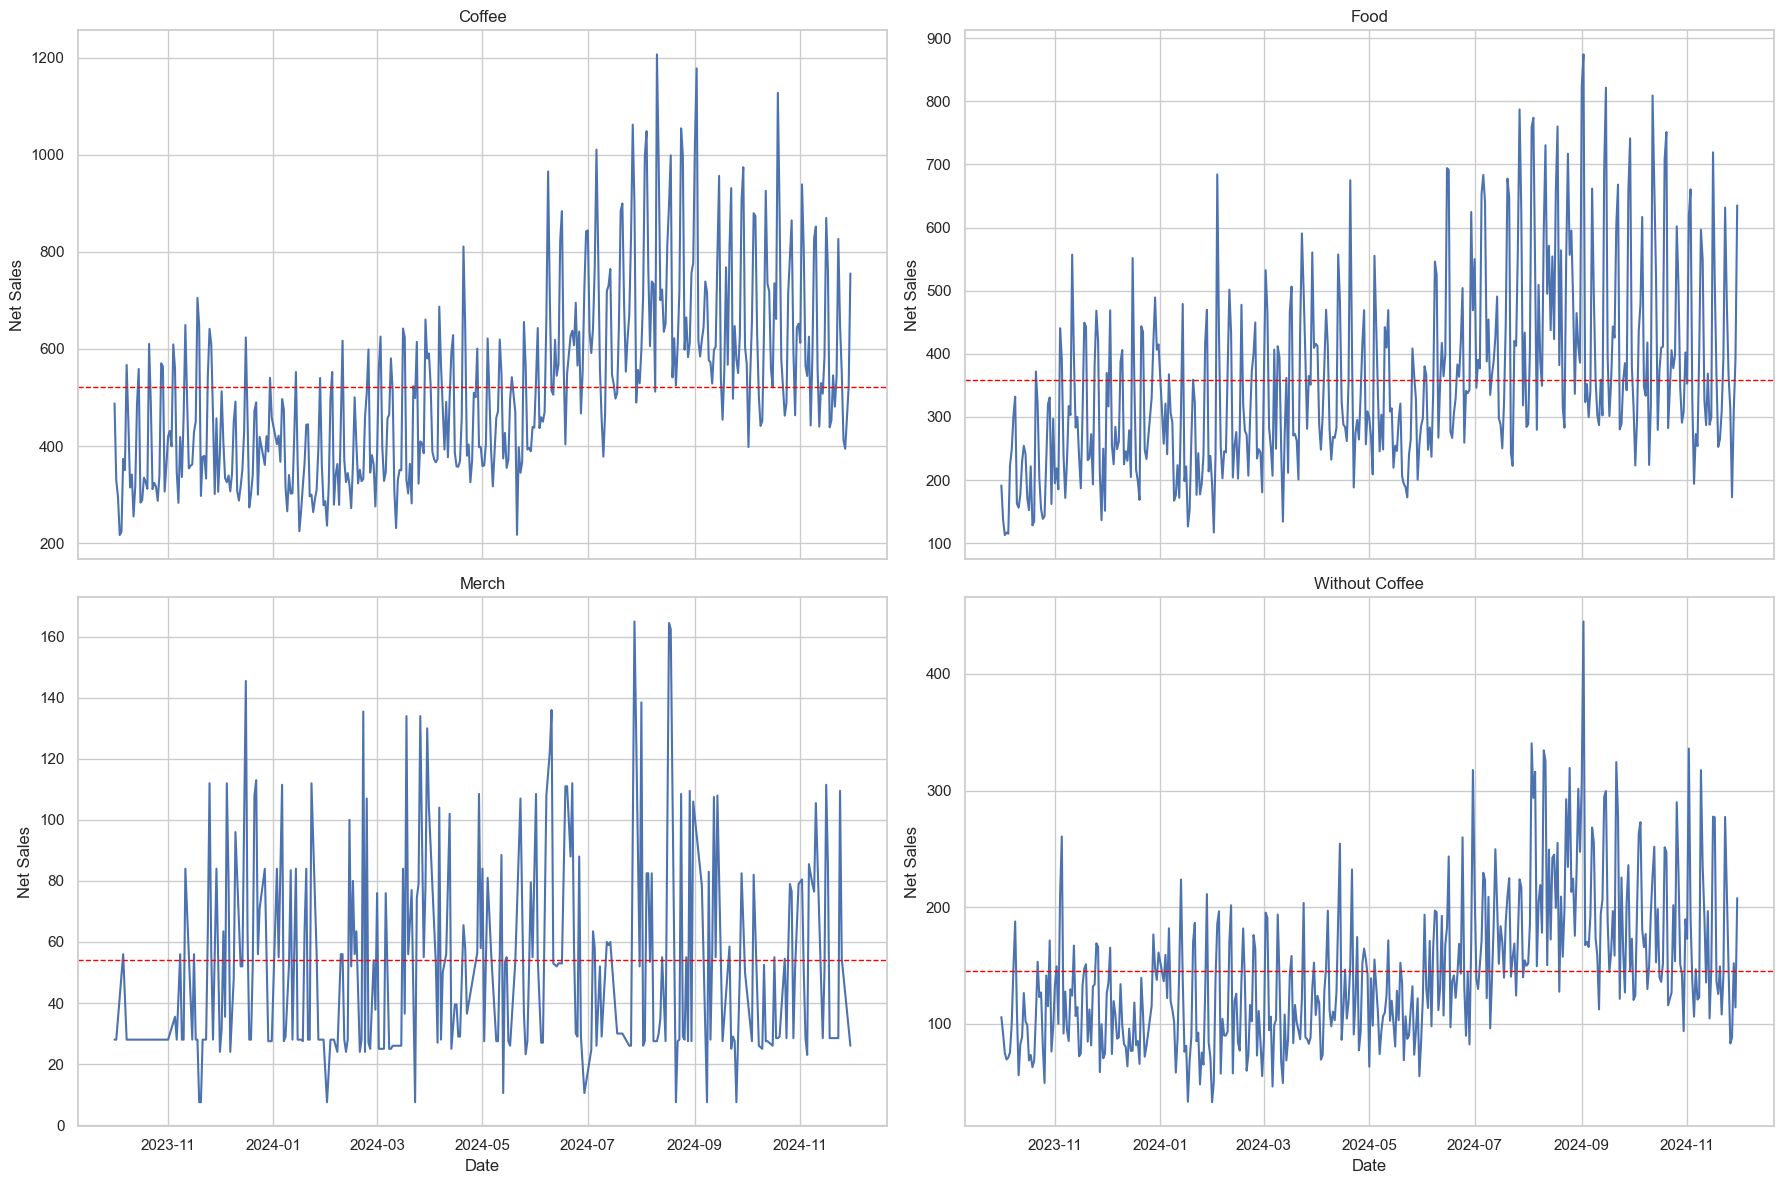

In [91]:
# Set the seaborn style
sns.set(style="whitegrid")

# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True)

# Plot each category
for ax, column in zip(axes.flatten(), category_sales.drop(columns='closed').columns):
    sns.lineplot(data=category_sales, x=category_sales.index, y=column, ax=ax)
    ax.axhline(category_sales[column].mean(), color='red', linestyle='--', linewidth=1)
    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Net Sales')

# Adjust layout
plt.tight_layout()
plt.show()

In [92]:
category_sales.drop(columns='closed').describe()

Category Name       Coffee        Food       Merch  Without Coffee
count           421.000000  421.000000  277.000000      421.000000
mean            522.027672  358.378029   53.950722      145.035938
std             188.559475  149.403909   33.166768       63.585073
min             216.400000  112.850000    7.500000       32.900000
25%             369.180000  249.700000   28.000000       97.150000
50%             496.700000  323.500000   50.500000      134.870000
75%             622.000000  423.450000   78.000000      177.050000
max            1207.170000  874.380000  165.000000      444.880000

In [93]:
mean_sales = category_sales.drop(columns='closed').mean().sort_values(ascending=False)
std_sales = category_sales.drop(columns='closed').std().sort_values(ascending=False)

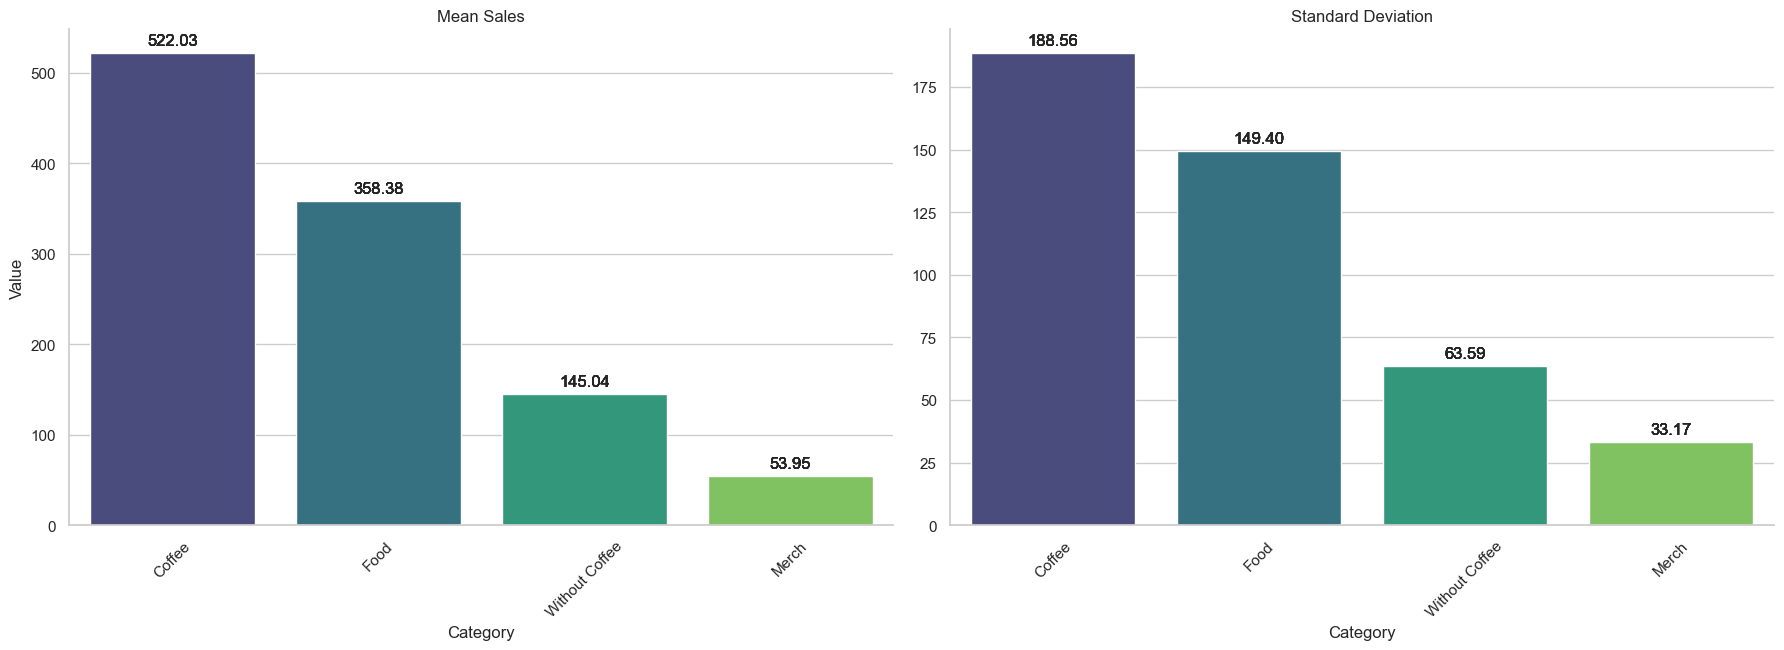

In [99]:
# Combine mean and standard deviation into a single DataFrame for easier plotting
sales_stats = pd.DataFrame({
    'Category': mean_sales.index,
    'Mean Sales': mean_sales.values,
    'Standard Deviation': std_sales.values
})

# Melt the DataFrame to long format for FacetGrid
sales_stats_melted = sales_stats.melt(id_vars='Category', var_name='Metric', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(sales_stats_melted, col='Metric', sharey=False, height=6, aspect=1.5)
g.map_dataframe(sns.barplot, x='Category', y='Value', palette='viridis', hue='Category', dodge=False)

# Adjust the titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Category', 'Value')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        # Add number labels on each bar
        for ax in g.axes.flat:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.show()


**NaN values**
- There are 6 rows which have NaN values when the store was closed. Except that the only other NaN values are observed in the categories `Merch`, `Food`, `Cold Coffee` due to no sales being made. The categories were available at all times.
- We can also see that the Merch category only reports sales in 49 days. That makes it very hard to predict. It would be a better approach to predict whether there's going to be sales for this category and not how much these sales will be.

In [ ]:
category_sales.fillna(0, inplace=True)

In [ ]:
category_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 2023-10-01 to 2024-11-30
Freq: D
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Coffee          427 non-null    float64
 1   Food            427 non-null    float64
 2   Merch           427 non-null    float64
 3   closed          427 non-null    int64  
 4   Without Coffee  427 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 20.0 KB


##### Description of the dataframe:

In [ ]:
category_data = pd.concat([category_sales, holiday_features, pedestrinization, time_features, macroeconomic, weather_clean, daily_sales], axis=1)

In [3]:
category_data.to_csv('data/category_data.csv')

NameError: name 'category_data' is not defined

- `Category`: Cateogy of products.
- `Net Sales`: Total net sales per day.
- `GDP, CPI, Unemployment Rate, Bond Yields`: Self-described macroeconomic indicators, forward filled to achieve daily frequency.
- `tavg`: Average temperature per day.
- `tmin`: Minimum temperature per day.
- `tmax`: Maximum temperature per day.
- `prcp`: Average precipitation total in mm per day.
- `snow`: Snow depth in mm per day.
- `wdir`: Average wind direction in degrees.
- `wspd`: Average wind speed per day.
- `pres`: Average sea level air pressure in hPa.
- `holiday_type`: Values (0, 1, 2) where 0 indicates not a holiday, 1 indicates a regular holiday, and 2 indicates a major holiday.
- `is_pedestrian`: Boolean flag (1 or 0) indicating whether the street where the cafe is located was pedestrianized on that day.
- `day_of_week`: Day of the week (0 = Monday, 6 = Sunday).
- `day_of_month`: Day of the month.
- `month`: Month of the year.
- `year`: Year.
- `quarter`: Quarter of the year (1 to 4).
- `is_weekend`: Boolean flag (1 or 0) indicating whether the day is a weekend.

In [4]:
category_data = pd.read_csv('data/category_data.csv', index_col = 0)
category_data.head()

Coffee    Food  Merch  closed  Without Coffee  holiday_type  \
2023-10-01  487.75  191.37   28.0       0          105.86             0   
2023-10-02  328.17  137.40   28.0       0           91.65             0   
2023-10-03  294.94  112.85    0.0       0           75.16             0   
2023-10-04  216.40  116.95    0.0       0           69.50             1   
2023-10-05  223.00  115.12    0.0       0           71.20             0   

            is_pedestrian  day_of_week  day_of_month  month  ...  Bond Yields  \
2023-10-01              0            6             1     10  ...        4.062   
2023-10-02              0            0             2     10  ...        4.062   
2023-10-03              0            1             3     10  ...        4.062   
2023-10-04              0            2             4     10  ...        4.062   
2023-10-05              0            3             5     10  ...        4.062   

            tavg  tmin  tmax  prcp  snow   wdir  wspd    pres  Net Sales  
2023-10-01  20.0  15.2  24.9   0.2   0.0  342.0   4.2  1023.5     852.98  
2023-10-02  18.6  13.2  24.1   1.1   0.0  326.0   2.7  1022.9     585.47  
2023-10-03  22.7  17.8  27.6   0.0   0.0  196.0   4.1  1018.5     504.45  
2023-10-04  24.5  18.7  30.3   0.0   0.0  178.0   3.6  1020.3     402.85  
2023-10-05  23.9  19.9  27.8   0.0   0.0  174.0   5.5  1018.2     413.62  

[5 rows x 26 columns]

In [5]:
# Swap the positions of the columns
cols = list(category_data.columns)
without_coffee_index = cols.index('Without Coffee')
closed_index = cols.index('closed')

# Swap the columns
cols[without_coffee_index], cols[closed_index] = cols[closed_index], cols[without_coffee_index]

# Reorder the DataFrame
category_data = category_data[cols]
category_data.head()

Coffee    Food  Merch  Without Coffee  closed  holiday_type  \
2023-10-01  487.75  191.37   28.0          105.86       0             0   
2023-10-02  328.17  137.40   28.0           91.65       0             0   
2023-10-03  294.94  112.85    0.0           75.16       0             0   
2023-10-04  216.40  116.95    0.0           69.50       0             1   
2023-10-05  223.00  115.12    0.0           71.20       0             0   

            is_pedestrian  day_of_week  day_of_month  month  ...  Bond Yields  \
2023-10-01              0            6             1     10  ...        4.062   
2023-10-02              0            0             2     10  ...        4.062   
2023-10-03              0            1             3     10  ...        4.062   
2023-10-04              0            2             4     10  ...        4.062   
2023-10-05              0            3             5     10  ...        4.062   

            tavg  tmin  tmax  prcp  snow   wdir  wspd    pres  Net Sales  
2023-10-01  20.0  15.2  24.9   0.2   0.0  342.0   4.2  1023.5     852.98  
2023-10-02  18.6  13.2  24.1   1.1   0.0  326.0   2.7  1022.9     585.47  
2023-10-03  22.7  17.8  27.6   0.0   0.0  196.0   4.1  1018.5     504.45  
2023-10-04  24.5  18.7  30.3   0.0   0.0  178.0   3.6  1020.3     402.85  
2023-10-05  23.9  19.9  27.8   0.0   0.0  174.0   5.5  1018.2     413.62  

[5 rows x 26 columns]

In [6]:
category_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 427 entries, 2023-10-01 to 2024-11-30
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Coffee             427 non-null    float64
 1   Food               427 non-null    float64
 2   Merch              427 non-null    float64
 3   Without Coffee     427 non-null    float64
 4   closed             427 non-null    int64  
 5   holiday_type       427 non-null    int64  
 6   is_pedestrian      427 non-null    int64  
 7   day_of_week        427 non-null    int64  
 8   day_of_month       427 non-null    int64  
 9   month              427 non-null    int64  
 10  year               427 non-null    int64  
 11  quarter            427 non-null    int64  
 12  is_weekend         427 non-null    int64  
 13  GDP                427 non-null    float64
 14  CPI                427 non-null    float64
 15  Unemployment Rate  427 non-null    float64
 16  Bond Yields    

##### Correlation

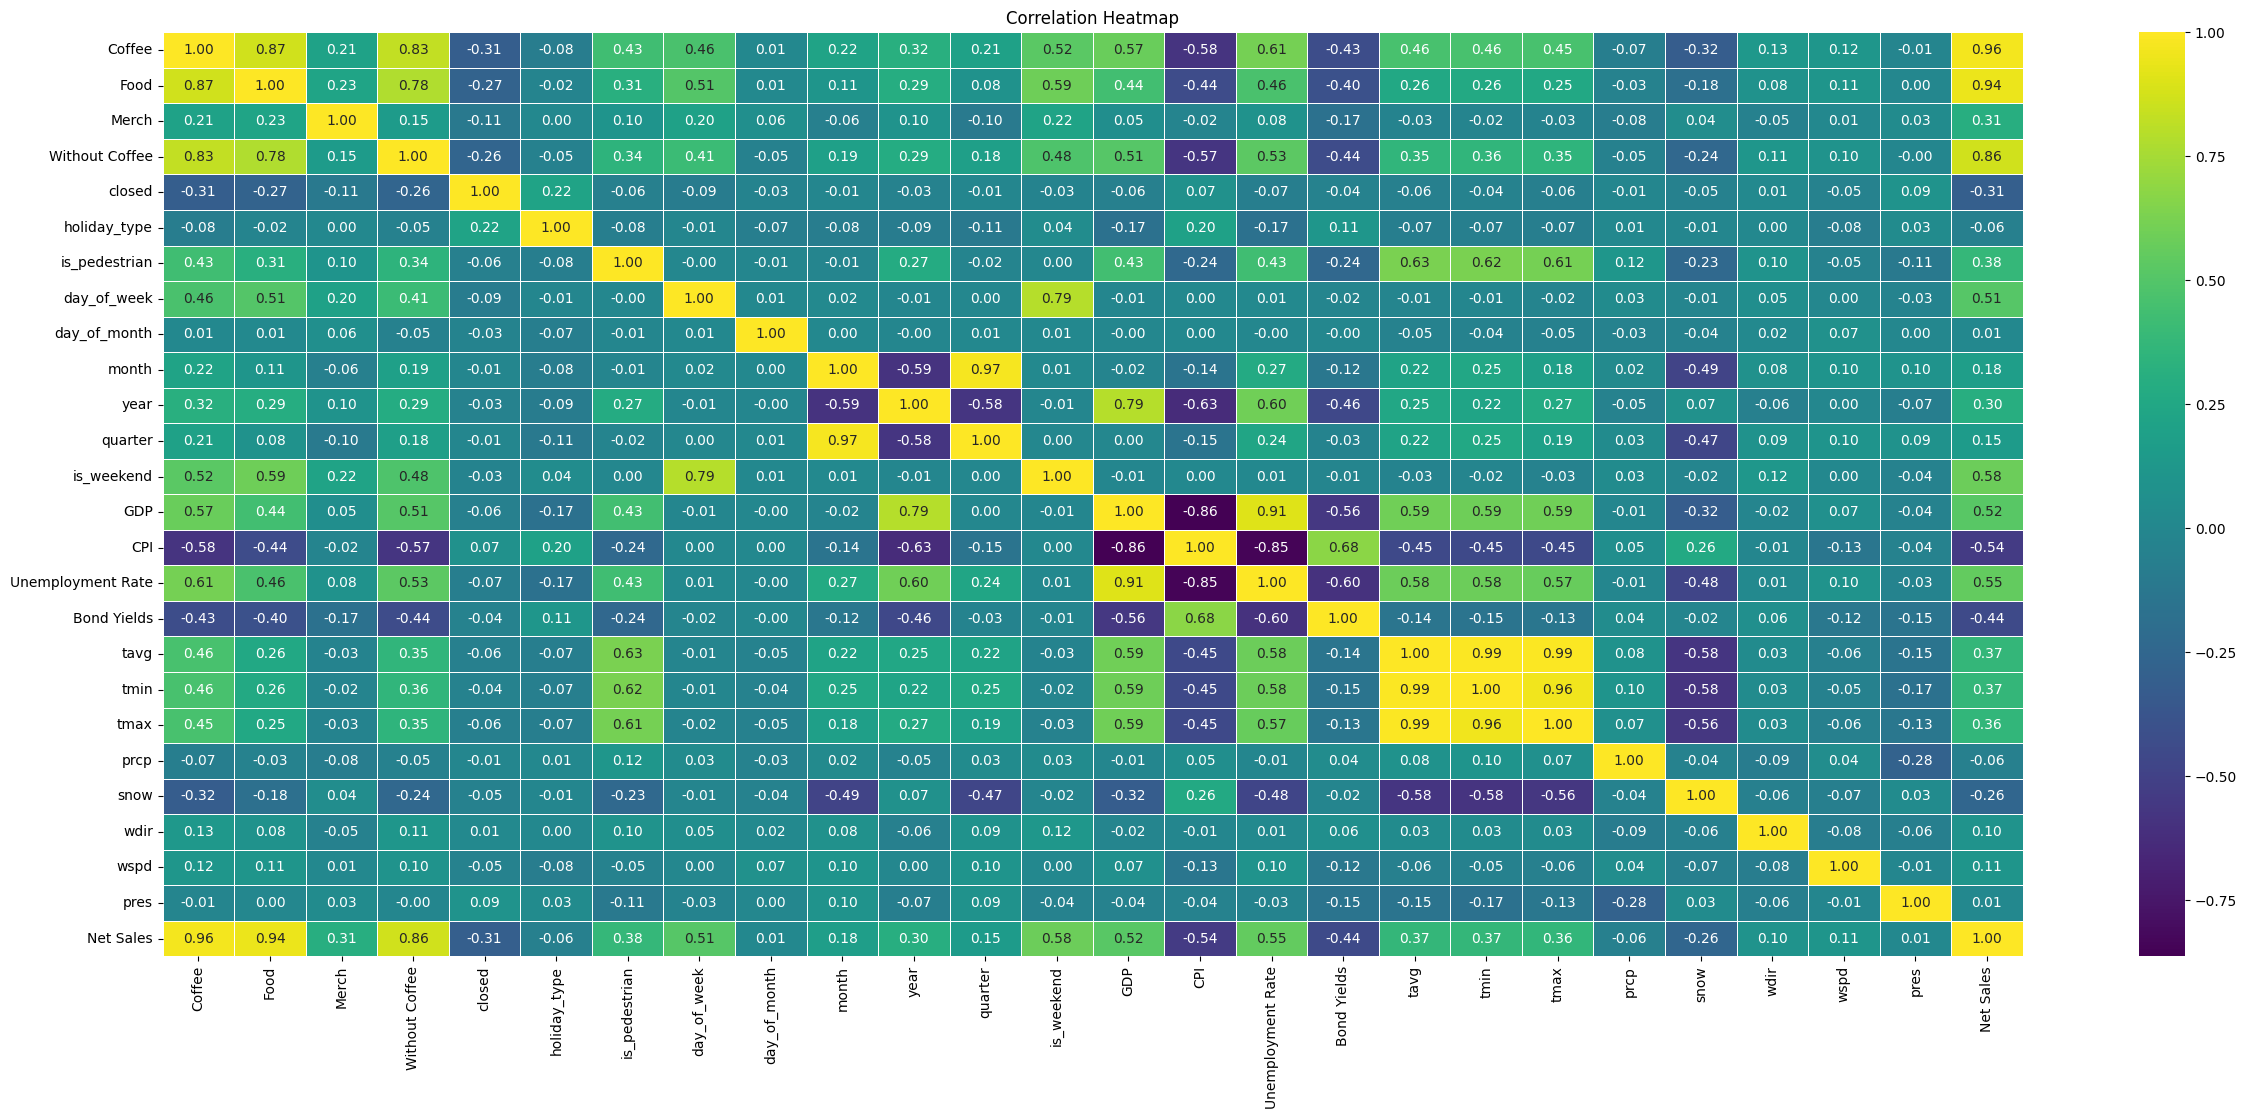

Coffee      Food     Merch  Without Coffee    closed  \
Coffee             1.000000  0.867346  0.213101        0.830675 -0.312149   
Food               0.867346  1.000000  0.227618        0.781524 -0.273802   
Merch              0.213101  0.227618  1.000000        0.153578 -0.112704   
Without Coffee     0.830675  0.781524  0.153578        1.000000 -0.261301   
closed            -0.312149 -0.273802 -0.112704       -0.261301  1.000000   
holiday_type      -0.082445 -0.022828  0.004262       -0.048821  0.216888   
is_pedestrian      0.430385  0.311175  0.099853        0.343713 -0.062128   
day_of_week        0.464838  0.505078  0.200770        0.410589 -0.089536   
day_of_month       0.007377  0.012783  0.058539       -0.054380 -0.030573   
month              0.220040  0.105513 -0.060578        0.189225 -0.008504   
year               0.315716  0.292534  0.095320        0.286563 -0.034227   
quarter            0.206445  0.077971 -0.101994        0.179350 -0.005384   
is_weekend         0.521593  0.588502  0.218201        0.479048 -0.031460   
GDP                0.571082  0.436313  0.048181        0.506420 -0.056422   
CPI               -0.582392 -0.439798 -0.024892       -0.572677  0.068679   
Unemployment Rate  0.612366  0.463970  0.075956        0.533764 -0.074436   
Bond Yields       -0.426813 -0.400257 -0.168030       -0.435638 -0.039047   
tavg               0.459402  0.256176 -0.028428        0.352725 -0.055948   
tmin               0.456328  0.261643 -0.024727        0.356798 -0.044206   
tmax               0.454902  0.253769 -0.032457        0.345782 -0.063182   
prcp              -0.072474 -0.034075 -0.076972       -0.052587 -0.005357   
snow              -0.323125 -0.183372  0.042221       -0.242197 -0.053055   
wdir               0.126955  0.081146 -0.050898        0.112933  0.014997   
wspd               0.115691  0.105546  0.006125        0.097647 -0.046892   
pres              -0.012813  0.001249  0.026316       -0.004320  0.091543   
Net Sales          0.963882  0.943113  0.308026        0.864997 -0.306795   

                   holiday_type  is_pedestrian   day_of_week  day_of_month  \
Coffee                -0.082445   4.303847e-01  4.648385e-01      0.007377   
Food                  -0.022828   3.111747e-01  5.050779e-01      0.012783   
Merch                  0.004262   9.985325e-02  2.007695e-01      0.058539   
Without Coffee        -0.048821   3.437133e-01  4.105893e-01     -0.054380   
closed                 0.216888  -6.212775e-02 -8.953562e-02     -0.030573   
holiday_type           1.000000  -7.633382e-02 -5.296717e-03     -0.072464   
is_pedestrian         -0.076334   1.000000e+00 -9.571439e-17     -0.005086   
day_of_week           -0.005297  -9.571439e-17  1.000000e+00      0.008373   
day_of_month          -0.072464  -5.086144e-03  8.372662e-03      1.000000   
month                 -0.083289  -1.222122e-02  1.610299e-02      0.004837   
year                  -0.088914   2.727235e-01 -8.544270e-03     -0.004789   
quarter               -0.106845  -2.182715e-02  3.029123e-03      0.006595   
is_weekend             0.035174   1.150541e-16  7.905694e-01      0.010423   
GDP                   -0.166536   4.338344e-01 -8.937568e-03     -0.000712   
CPI                    0.199984  -2.357657e-01  4.380349e-03      0.004809   
Unemployment Rate     -0.170031   4.315785e-01  1.252971e-02     -0.000278   
Bond Yields            0.114184  -2.421492e-01 -1.805191e-02     -0.000905   
tavg                  -0.073621   6.256704e-01 -1.333479e-02     -0.045405   
tmin                  -0.068321   6.238070e-01 -6.774333e-03     -0.036792   
tmax                  -0.074931   6.108276e-01 -1.943269e-02     -0.050675   
prcp                   0.008519   1.181087e-01  3.171659e-02     -0.034048   
snow                  -0.011064  -2.312825e-01 -1.311171e-02     -0.038844   
wdir                   0.004227   9.767783e-02  5.137518e-02      0.017378   
wspd                  -0.080910  -4.734979e-02  2.374794e-03      0.0

In [7]:
vs.plot_correlation_heatmap(category_data)

In [8]:
category_data = pd.get_dummies(category_data, columns=['quarter', 'day_of_week', 'holiday_type'])

In [9]:
category_data = category_data.drop(columns = ['Net Sales'])
category_data = category_data.drop(columns = ['day_of_month', 'month', 'prcp', 'pres', 'wdir', 'tmin', 'tmax'])

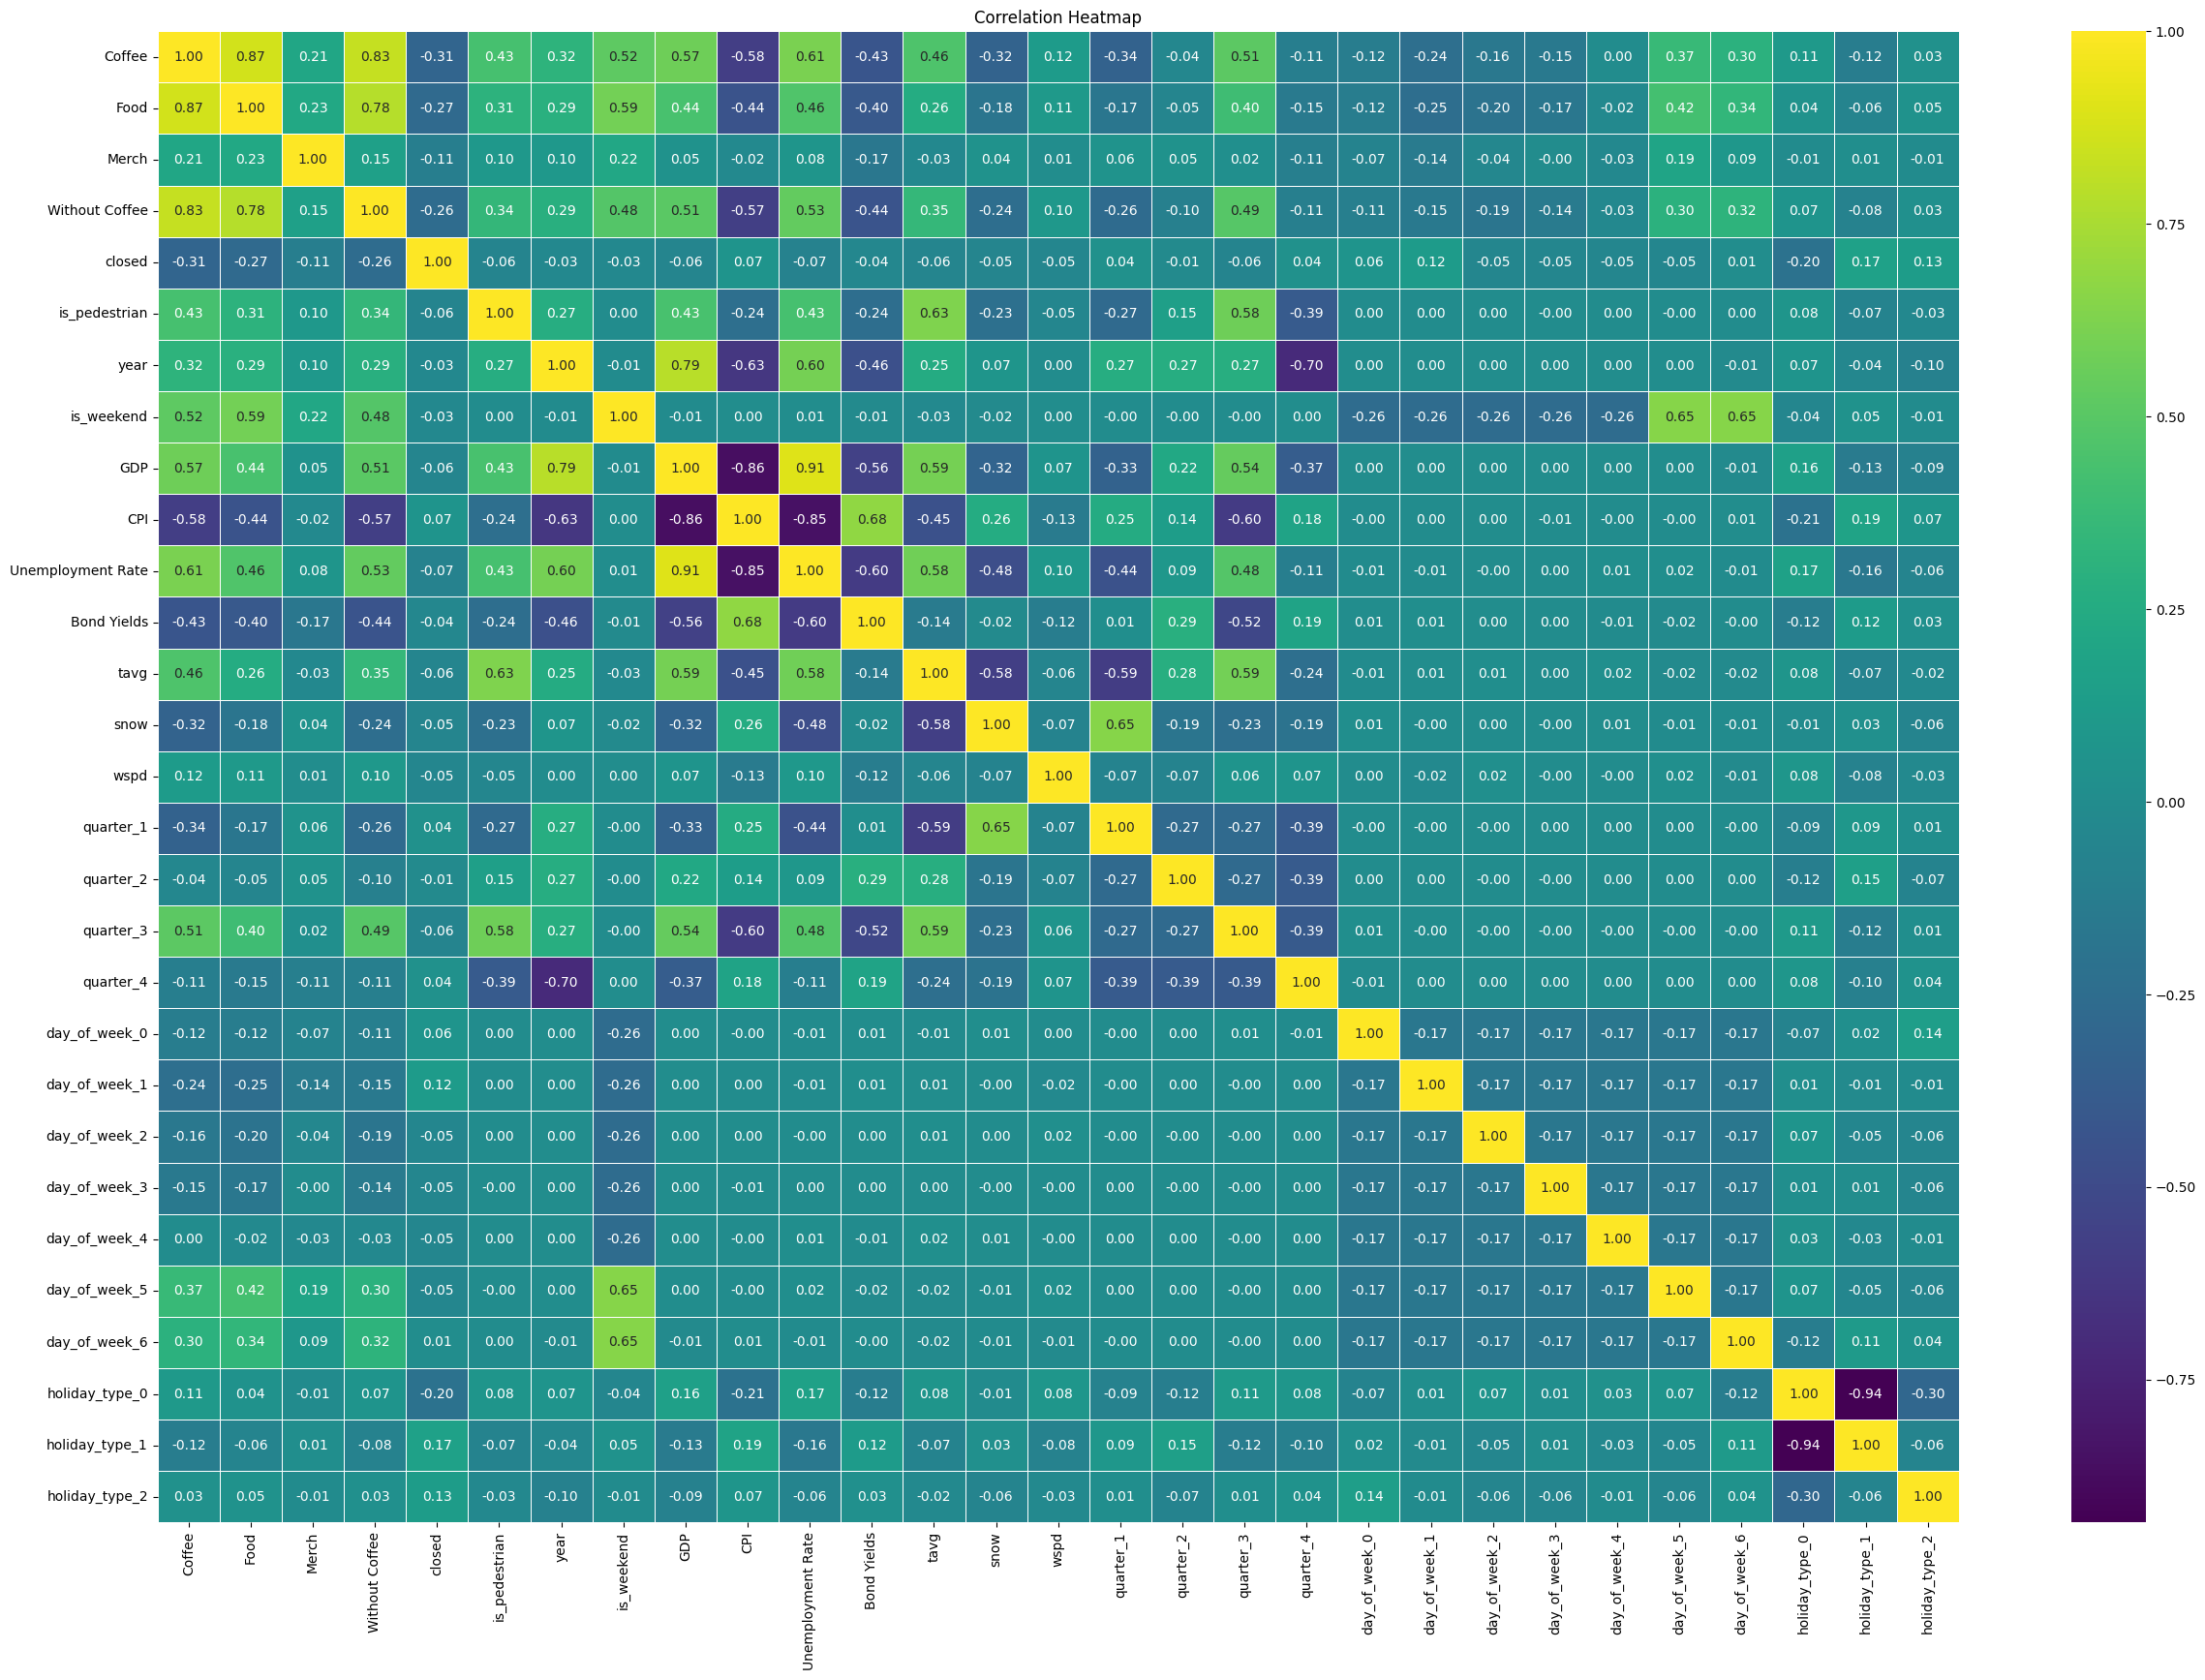

In [10]:
corr_matrix = vs.plot_correlation_heatmap(category_data, figsize=(30, 20))

- The `holiday_type` features seem to have no direct impact on sales (max abs correlation (0.12))
- There are some features that are redundant.
    - `day_of_week_5` and `day_of_week_6` are highly correlated with `is_weekend` since they are representing the same information.

In [11]:
category_data = category_data.drop(columns = ['day_of_week_5', 'day_of_week_6'])

##### Feature importance (XGBoost)

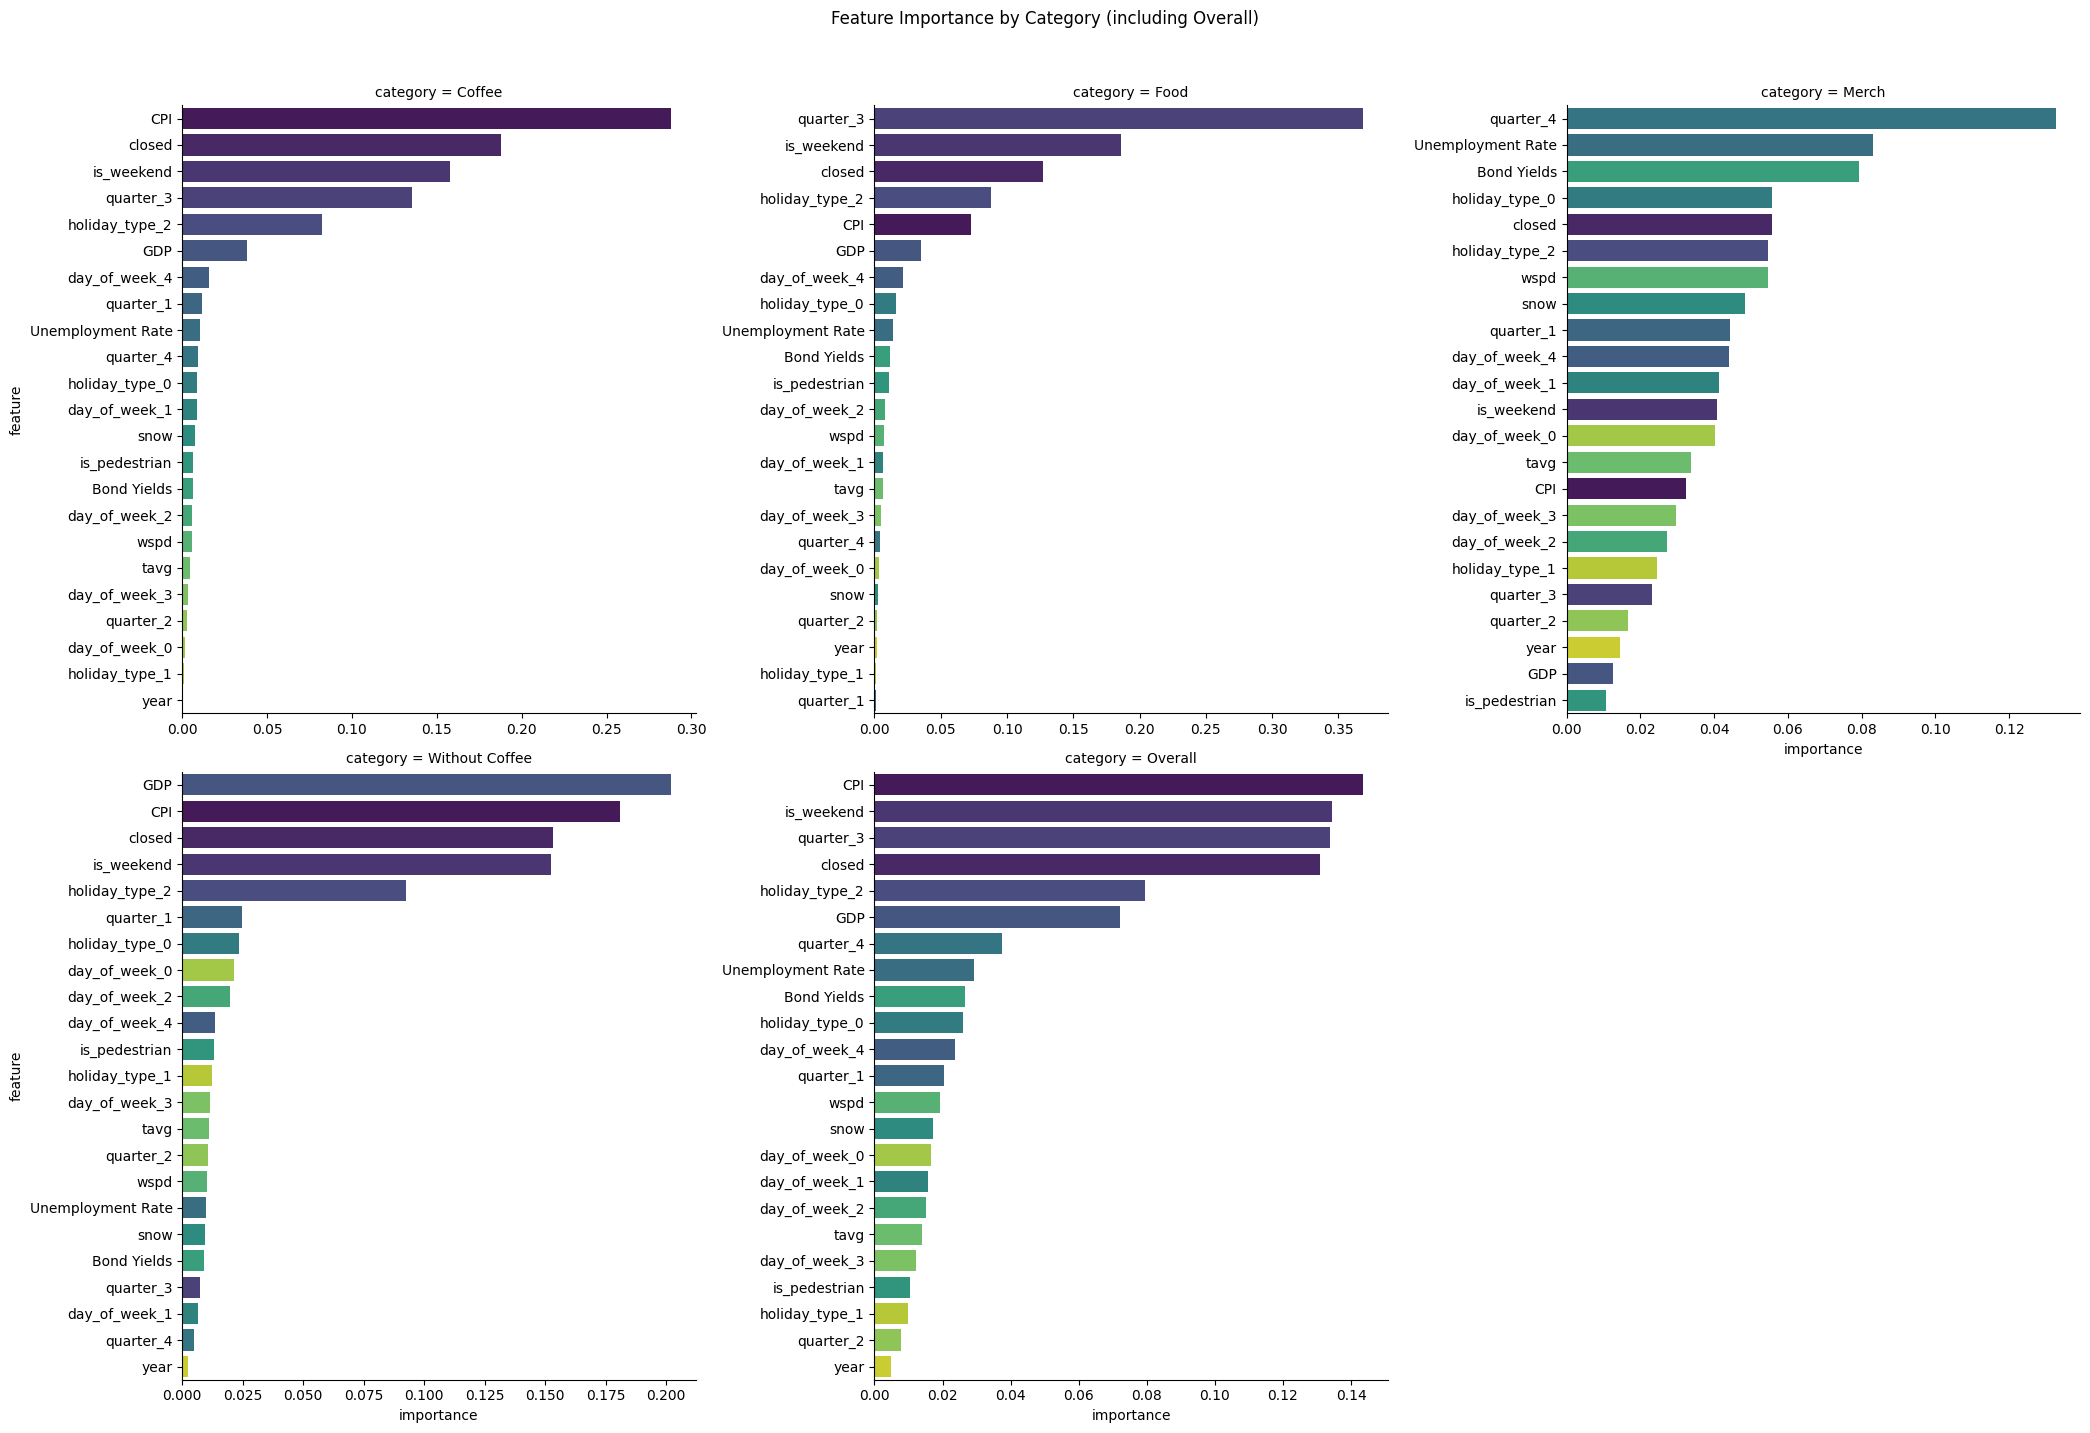

In [12]:
# Feature importnance for the first seven columns (categories)
categories = category_data.columns[:4]
importance_data = mt.analyze_category_feature_importance(category_data, categories)

**Insights from feature importance analysis**
- **Net Sales** 
    - The total `Net Sales` is the most important feature however that's expected since it has a very high correlation with the categories, since the sum of the categories forms the total net sales.
- **Holiday type**
    - The `holiday_type_2` feature seem to provide valuable information to the model afterall, even though it didn't have direct impact on sales as shown from the correlation analysis.
- **Macroeconomic features**
    - They seem to also play an important role, with `CPI` and `Unemployment Rate` being the most important features for almost all categories and ranked 2nd overall.
- **Weather**
    - The wind and temperature features are the next most relevant features
- **Time based features**
    - These features seem to play a role in the decision making for XGBoost, however they have smaller impact than expected.

##### Macroconomic feature analysis

We've seen that the features `GDP`, `CPI`, `Unemployment Rate`, `Bond Yields` are significantly correlated with the sales per category, but there seems to be correlation with other features leading to doubts over whether the impact on sales is due to the seasonality of the indicators.

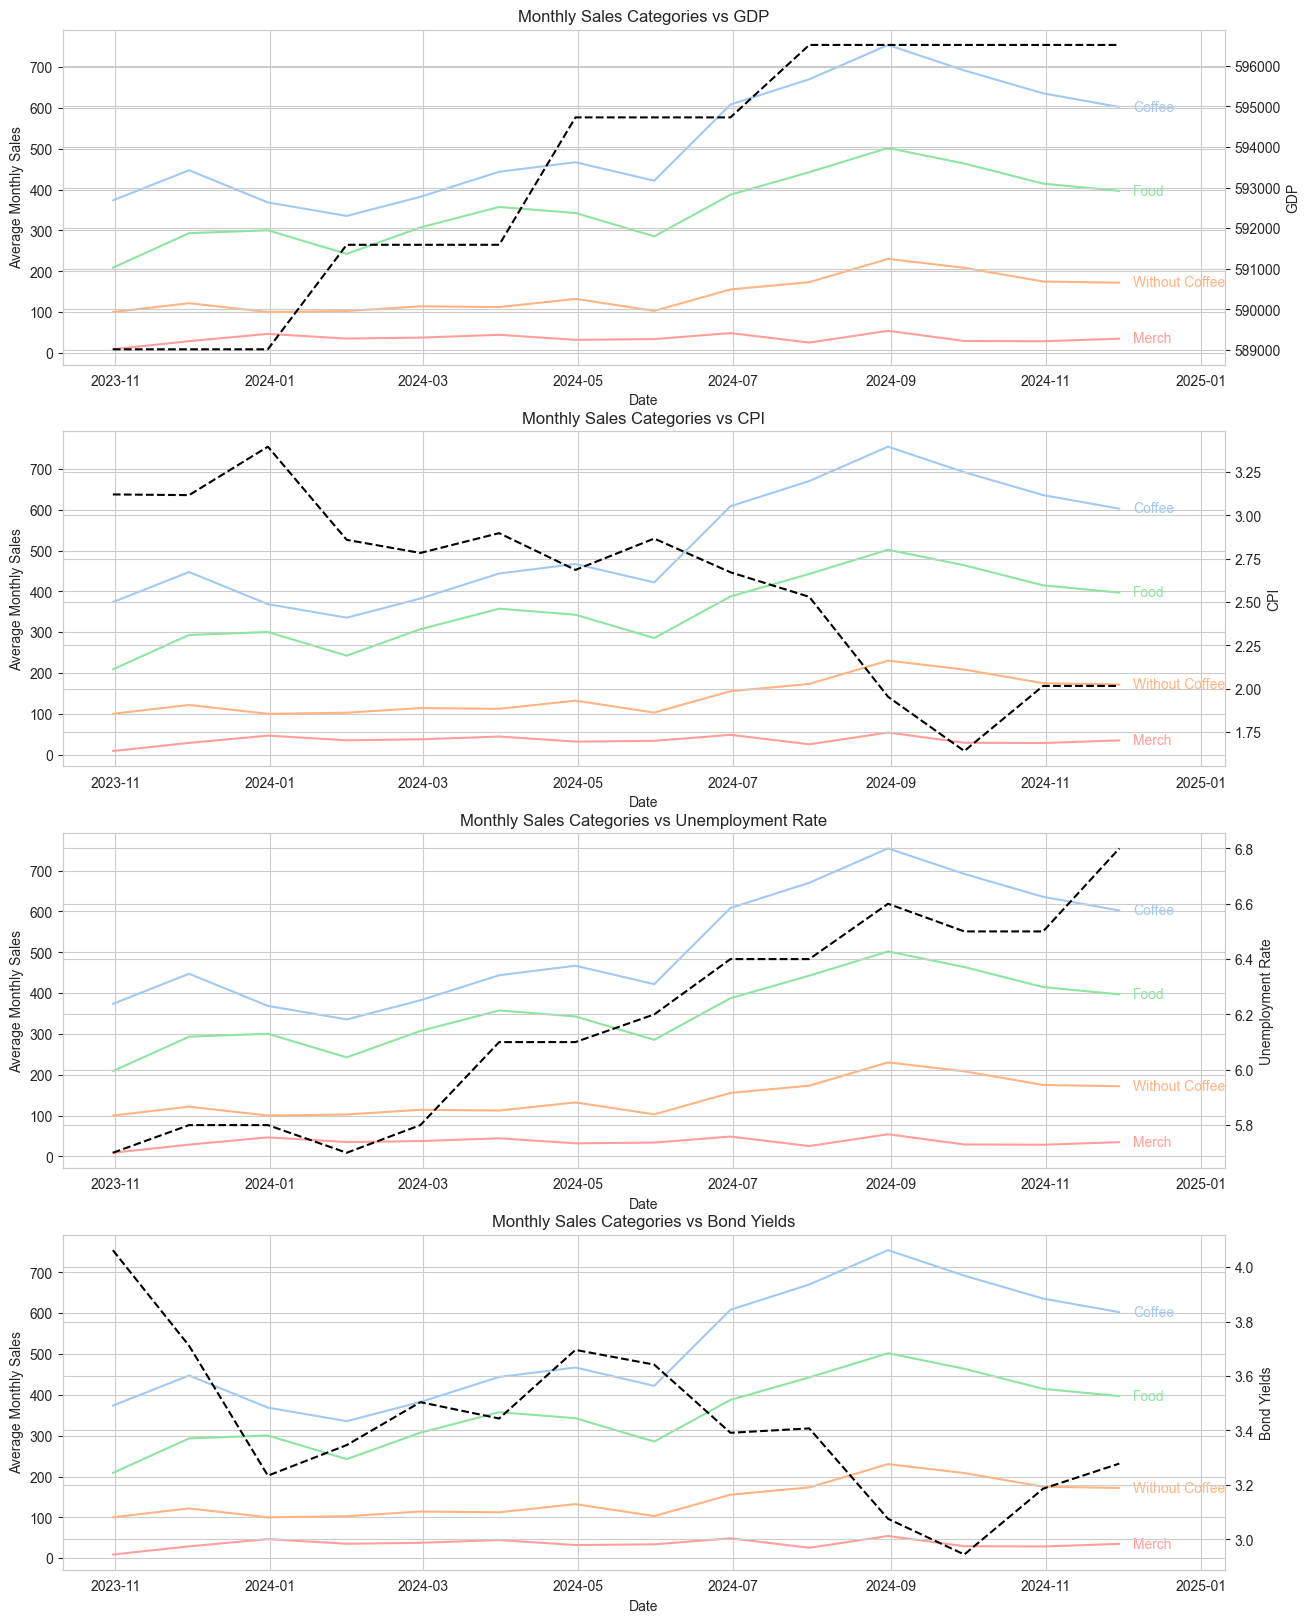

In [13]:
vs.plot_monthly_sales_vs_macro(category_data)

In [14]:
lags = [7, 10, 14]
cols = ['GDP', 'CPI', 'Unemployment Rate', 'Bond Yields']
category_data = fe.create_lag_features(category_data, cols, lags).fillna(method='bfill')

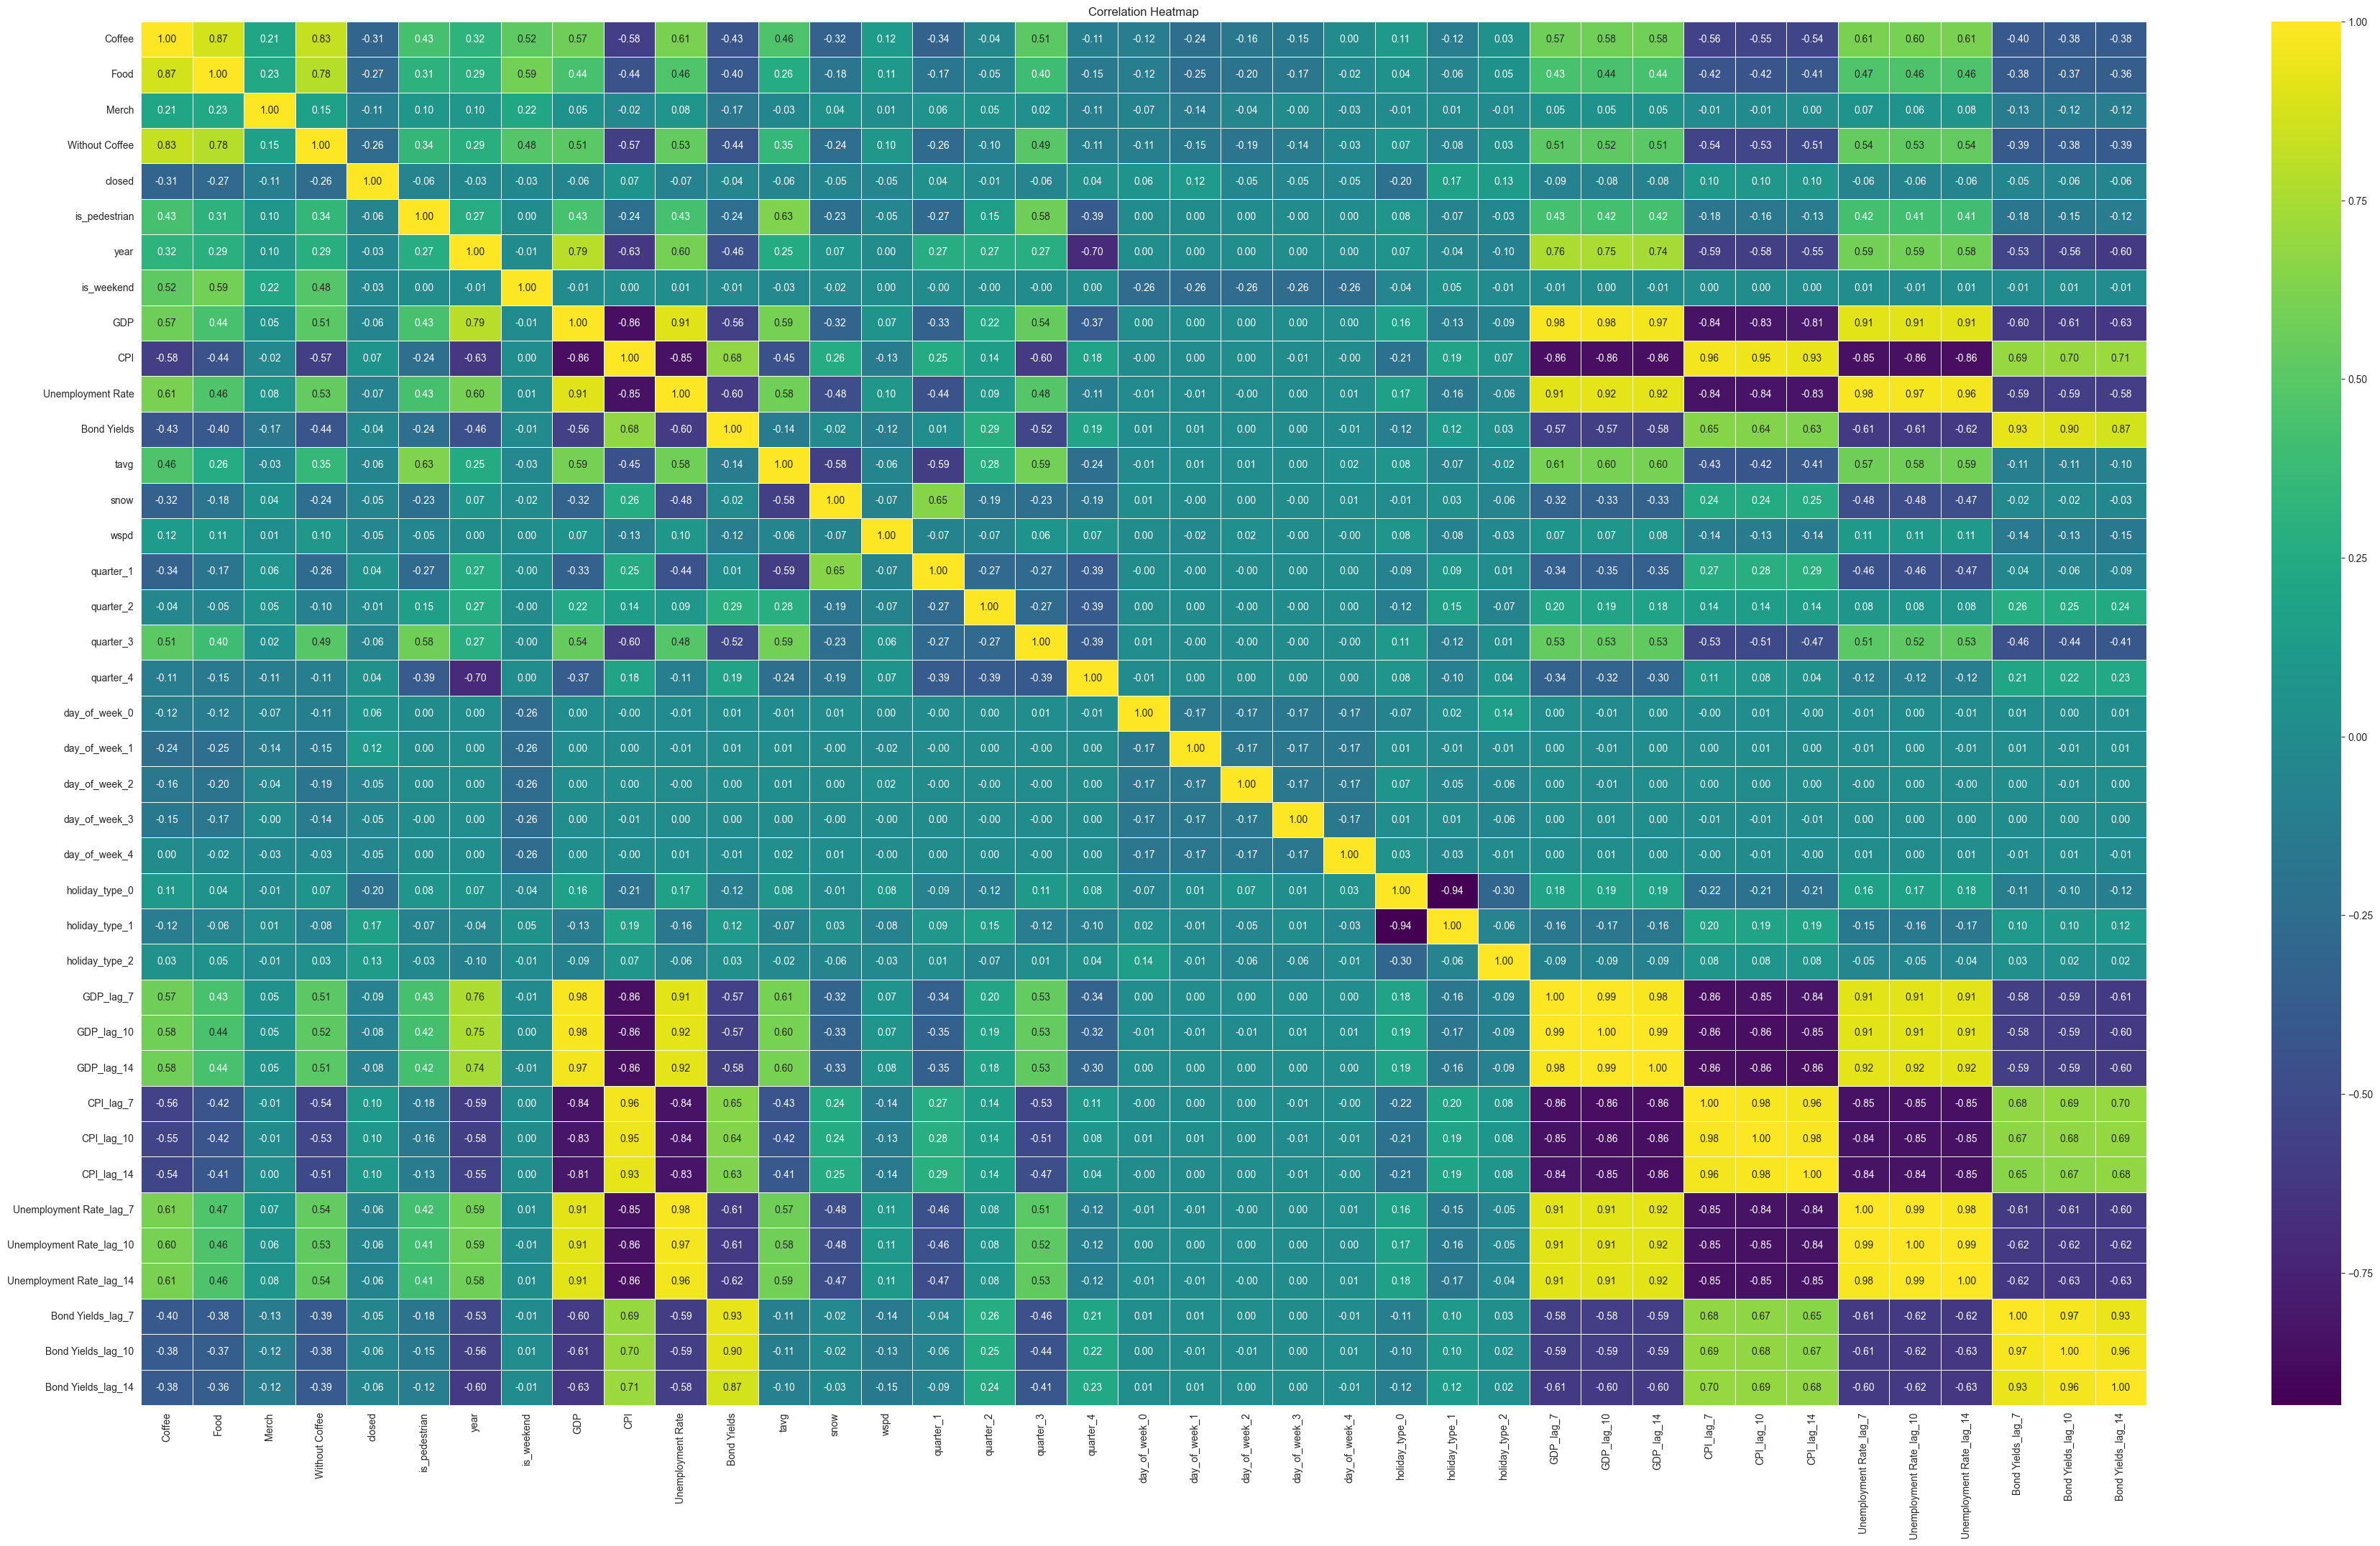

Coffee      Food     Merch  Without Coffee  \
Coffee                    1.000000  0.867346  0.213101        0.830675   
Food                      0.867346  1.000000  0.227618        0.781524   
Merch                     0.213101  0.227618  1.000000        0.153578   
Without Coffee            0.830675  0.781524  0.153578        1.000000   
closed                   -0.312149 -0.273802 -0.112704       -0.261301   
is_pedestrian             0.430385  0.311175  0.099853        0.343713   
year                      0.315716  0.292534  0.095320        0.286563   
is_weekend                0.521593  0.588502  0.218201        0.479048   
GDP                       0.571082  0.436313  0.048181        0.506420   
CPI                      -0.582392 -0.439798 -0.024892       -0.572677   
Unemployment Rate         0.612366  0.463970  0.075956        0.533764   
Bond Yields              -0.426813 -0.400257 -0.168030       -0.435638   
tavg                      0.459402  0.256176 -0.028428        0.352725   
snow                     -0.323125 -0.183372  0.042221       -0.242197   
wspd                      0.115691  0.105546  0.006125        0.097647   
quarter_1                -0.336381 -0.171888  0.058796       -0.264863   
quarter_2                -0.043116 -0.051261  0.045560       -0.102641   
quarter_3                 0.508709  0.395801  0.021249        0.490009   
quarter_4                -0.112081 -0.148795 -0.107341       -0.106289   
day_of_week_0            -0.121970 -0.120003 -0.071202       -0.111188   
day_of_week_1            -0.238605 -0.245400 -0.137367       -0.151899   
day_of_week_2            -0.163912 -0.200745 -0.038824       -0.185036   
day_of_week_3            -0.149742 -0.169734 -0.003720       -0.140117   
day_of_week_4             0.000855 -0.023871 -0.030583       -0.030208   
holiday_type_0            0.107256  0.043735 -0.009383        0.067589   
holiday_type_1           -0.124616 -0.063851  0.014468       -0.082315   
holiday_type_2            0.033725  0.048936 -0.012574        0.031471   
GDP_lag_7                 0.572782  0.433999  0.050905        0.510479   
GDP_lag_10                0.580638  0.441537  0.052848        0.517771   
GDP_lag_14                0.578436  0.437630  0.049021        0.506874   
CPI_lag_7                -0.557007 -0.421598 -0.010797       -0.542436   
CPI_lag_10               -0.546010 -0.421914 -0.009309       -0.531573   
CPI_lag_14               -0.535536 -0.413604  0.004975       -0.508546   
Unemployment Rate_lag_7   0.613286  0.467519  0.067960        0.535952   
Unemployment Rate_lag_10  0.600625  0.458889  0.058207        0.526955   
Unemployment Rate_lag_14  0.610485  0.462271  0.076122        0.536072   
Bond Yields_lag_7        -0.403861 -0.380474 -0.129787       -0.394118   
Bond Yields_lag_10       -0.382898 -0.365838 -0.119181       -0.379943   
Bond Yields_lag_14       -0.382038 -0.361107 -0.119296       -0.385034   

                            closed  is_pedestrian      year    is_weekend  \
Coffee                   -0.312149   4.303847e-01  0.315716  5.215929e-01   
Food                     -0.273802   3.111747e-01  0.292534  5.885025e-01   
Merch                    -0.112704   9.985325e-02  0.095320  2.182010e-01   
Without Coffee           -0.261301   3.437133e-01  0.286563  4.790482e-01   
closed                    1.000000  -6.212775e-02 -0.034227 -3.145961e-02   
is_pedestrian            -0.062128   1.000000e+00  0.272724  1.150541e-16   
year                     -0.034227   2.727235e-01  1.000000 -9.006451e-03   
is_weekend               -0.031460   1.150541e-16 -0.009006  1.000000e+00   
GDP                      -0.056422   4.338344e-01  0.791802 -9.421024e-03   
CPI                       0.068679  -2.357657e-01 -0.631411  4.029909e-03   
Unemployment Rate        -0.074436   4.315785e-01  0.597826  7.090329e-03   
Bond Yields              -0.039047  -2.421492e-01 -0.460557 -1.319831e-02   
tavg                     -0.055948   6.256704e-01  0.248087 -2.704

In [15]:
corr_matrix = vs.plot_correlation_heatmap(category_data, figsize=(45, 25))
corr_matrix

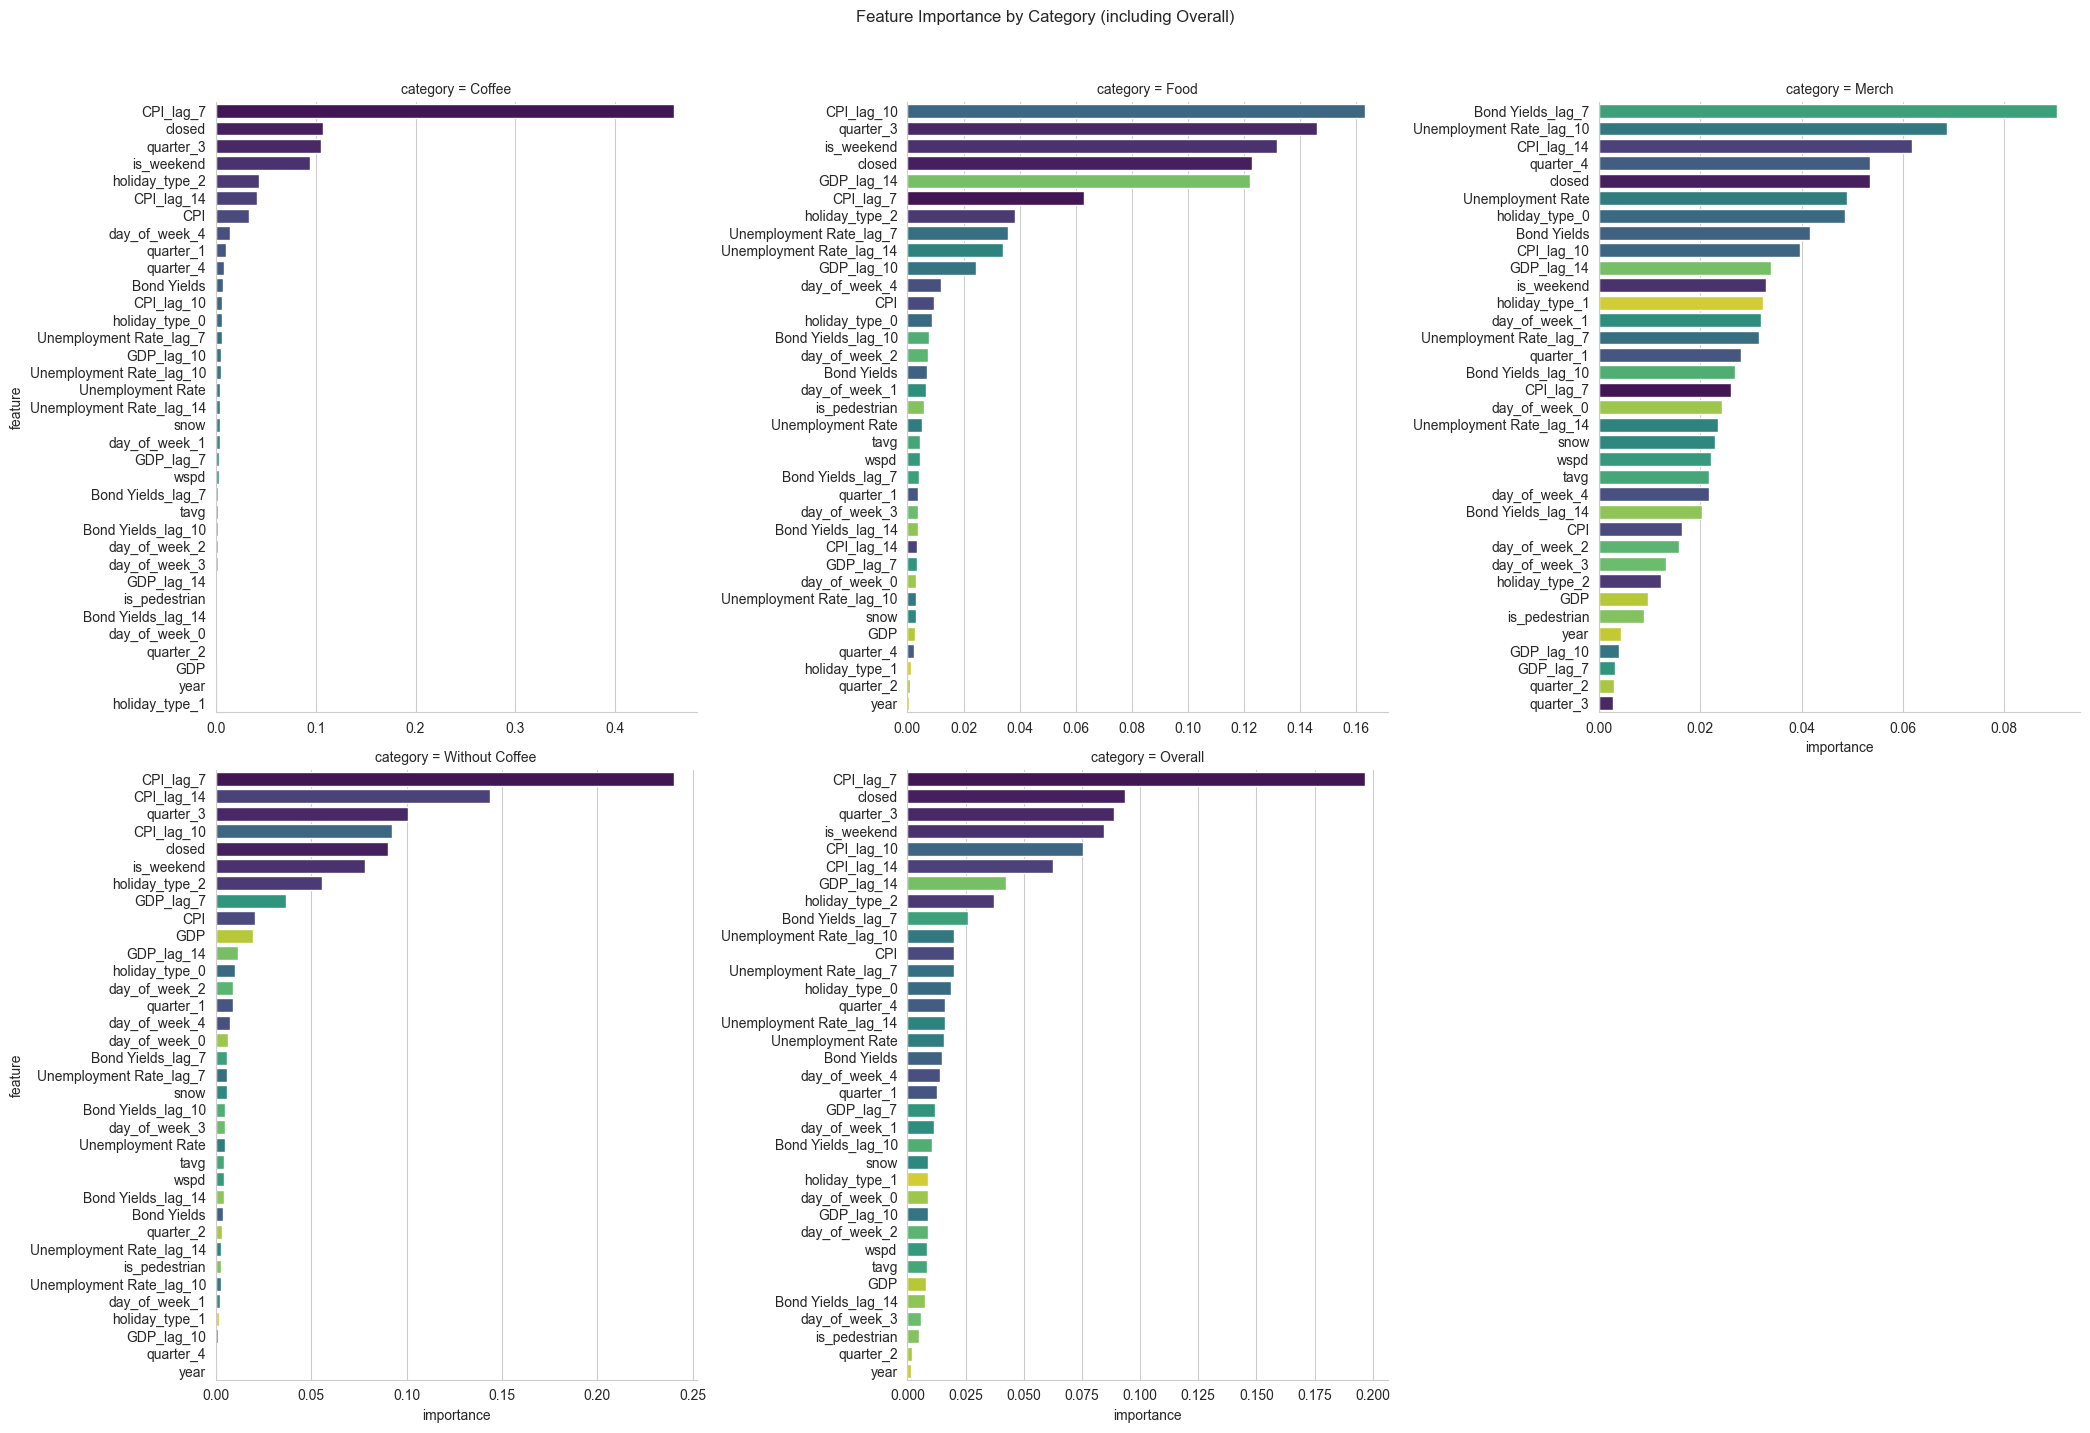

feature  importance category
140                 CPI_lag_7    0.196847  Overall
141                    closed    0.093594  Overall
142                 quarter_3    0.088863  Overall
143                is_weekend    0.084320  Overall
144                CPI_lag_10    0.075452  Overall
145                CPI_lag_14    0.062503  Overall
146                GDP_lag_14    0.042368  Overall
147            holiday_type_2    0.037199  Overall
148         Bond Yields_lag_7    0.025844  Overall
149  Unemployment Rate_lag_10    0.020040  Overall
150                       CPI    0.020017  Overall
151   Unemployment Rate_lag_7    0.019903  Overall
152            holiday_type_0    0.018614  Overall
153                 quarter_4    0.016257  Overall
154  Unemployment Rate_lag_14    0.016243  Overall
155         Unemployment Rate    0.015820  Overall
156               Bond Yields    0.014892  Overall
157             day_of_week_4    0.013956  Overall
158                 quarter_1    0.012807  Overall
159                 GDP_lag_7    0.011716  Overall
160             day_of_week_1    0.011402  Overall
161        Bond Yields_lag_10    0.010499  Overall
162                      snow    0.008964  Overall
163            holiday_type_1    0.008908  Overall
164             day_of_week_0    0.008799  Overall
165                GDP_lag_10    0.008777  Overall
166             day_of_week_2    0.008728  Overall
167                      wspd    0.008449  Overall
168                      tavg    0.008329  Overall
169                       GDP    0.008110  Overall
170        Bond Yields_lag_14    0.007477  Overall
171             day_of_week_3    0.005928  Overall
172             is_pedestrian    0.004889  Overall
173                 quarter_2    0.002131  Overall
174                      year    0.001355  Overall

In [16]:
importance = mt.analyze_category_feature_importance(category_data, categories)
overall_importance = importance.loc[importance['category'] == 'Overall'].sort_values(by='importance', ascending=False)
overall_importance

We can see that the lag features are highly relevant overall, especially the lag features of CPI and the lag features of 7 and 14 days in generall. <br>
This indicates that the macroeconomic can be predictors of the category sales. <br>
Since we see strong performance between 7 and 14 days it would be good idea to add a lag feature of 10 days. <br>
However, there are features that seem to have very low feature importance and it might benefit our model if we remove them with the exception of certain features that due to domain_knowledge we know that have an effect on sales.

In [17]:
# Removing features that have less than 0.01 feature importance
low_features = overall_importance.loc[(overall_importance['importance'] < 0.01) & (~overall_importance['feature'].isin(['snow', 'is_pedestrian', 'prcp']))]
category_data_filtered = category_data.drop(columns=low_features['feature'])
category_data_filtered.columns

Index(['Coffee', 'Food', 'Merch', 'Without Coffee', 'closed', 'is_pedestrian',
       'is_weekend', 'CPI', 'Unemployment Rate', 'Bond Yields', 'snow',
       'quarter_1', 'quarter_3', 'quarter_4', 'day_of_week_1', 'day_of_week_4',
       'holiday_type_0', 'holiday_type_2', 'GDP_lag_7', 'GDP_lag_14',
       'CPI_lag_7', 'CPI_lag_10', 'CPI_lag_14', 'Unemployment Rate_lag_7',
       'Unemployment Rate_lag_10', 'Unemployment Rate_lag_14',
       'Bond Yields_lag_7', 'Bond Yields_lag_10'],
      dtype='object')

In [147]:
category_data_filtered.to_csv('data/category_data_filtered.csv')

## Modeling

We are going to be using GridSearch to compare XGBoost and LightGBM

In [91]:
category_data_filtered = pd.read_csv('data/category_data_filtered.csv', index_col=0)
category_data_filtered.head()

Coffee    Food  Merch  Without Coffee  closed  is_pedestrian  \
2023-10-01  487.75  191.37   28.0          105.86       0              0   
2023-10-02  328.17  137.40   28.0           91.65       0              0   
2023-10-03  294.94  112.85    0.0           75.16       0              0   
2023-10-04  216.40  116.95    0.0           69.50       0              0   
2023-10-05  223.00  115.12    0.0           71.20       0              0   

            is_weekend       CPI  Unemployment Rate  Bond Yields  ...  \
2023-10-01           1  3.120936                5.7        4.062  ...   
2023-10-02           0  3.120936                5.7        4.062  ...   
2023-10-03           0  3.120936                5.7        4.062  ...   
2023-10-04           0  3.120936                5.7        4.062  ...   
2023-10-05           0  3.120936                5.7        4.062  ...   

            holiday_type_0  holiday_type_2  GDP_lag_14  CPI_lag_7  CPI_lag_10  \
2023-10-01            True           False    589018.5   3.120936    3.120936   
2023-10-02            True           False    589018.5   3.120936    3.120936   
2023-10-03            True           False    589018.5   3.120936    3.120936   
2023-10-04           False           False    589018.5   3.120936    3.120936   
2023-10-05            True           False    589018.5   3.120936    3.120936   

            CPI_lag_14  Unemployment Rate_lag_7  Unemployment Rate_lag_10  \
2023-10-01    3.120936                      5.7                       5.7   
2023-10-02    3.120936                      5.7                       5.7   
2023-10-03    3.120936                      5.7                       5.7   
2023-10-04    3.120936                      5.7                       5.7   
2023-10-05    3.120936                      5.7                       5.7   

            Unemployment Rate_lag_14  Bond Yields_lag_7  
2023-10-01                       5.7              4.062  
2023-10-02                       5.7              4.062  
2023-10-03                       5.7              4.062  
2023-10-04                       5.7              4.062  
2023-10-05                       5.7              4.062  

[5 rows x 26 columns]

In [92]:
# Convert boolean features to integers
bool_columns = category_data_filtered.select_dtypes(include='bool').columns
category_data_filtered[bool_columns] = category_data_filtered[bool_columns].astype(int)

##### Extra feature engineering

In [93]:
# Create a new column 'before_holiday' initialized to 0
category_data_filtered['before_holiday'] = 0

# Convert the index to datetime
category_data_filtered.index = pd.to_datetime(category_data_filtered.index)

# Get the dates where holiday_type_1 is 1
holiday_dates = category_data_filtered[category_data_filtered['holiday_type_2'] == 1].index

# Iterate over each holiday date and set 'before_holiday' to 1 for the 3 days before the holiday
for holiday_date in holiday_dates:
    for i in range(1, 5):
        before_date = holiday_date - pd.Timedelta(days=i)
        if before_date in category_data_filtered.index:
            category_data_filtered.at[before_date, 'before_holiday'] = 1

In [94]:
category_data_filtered['tmax_weekend'] = category_data_filtered['tmax'] * category_data_filtered['is_weekend']

In [7]:
category_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 2023-10-01 to 2024-11-30
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Coffee                    427 non-null    float64
 1   Food                      427 non-null    float64
 2   Merch                     427 non-null    float64
 3   Without Coffee            427 non-null    float64
 4   closed                    427 non-null    int64  
 5   is_pedestrian             427 non-null    int64  
 6   is_weekend                427 non-null    int64  
 7   CPI                       427 non-null    float64
 8   Unemployment Rate         427 non-null    float64
 9   Bond Yields               427 non-null    float64
 10  tmax                      427 non-null    float64
 11  prcp                      427 non-null    float64
 12  snow                      427 non-null    float64
 13  quarter_3                 427 non-null    int6

In [95]:
category_data_filtered.sort_index(inplace=True)

In [96]:
category_data_filtered.to_csv('data/data_final.csv')

In [97]:
data_final = pd.read_csv('data/data_final.csv', index_col=0)

In [115]:
categories = ['Coffee', 'Without Coffee', 'Food']

**Removing outliers** <br>
> After testing treshold = 3 works best for XGBoost and treshold = 2 works best for Ridge

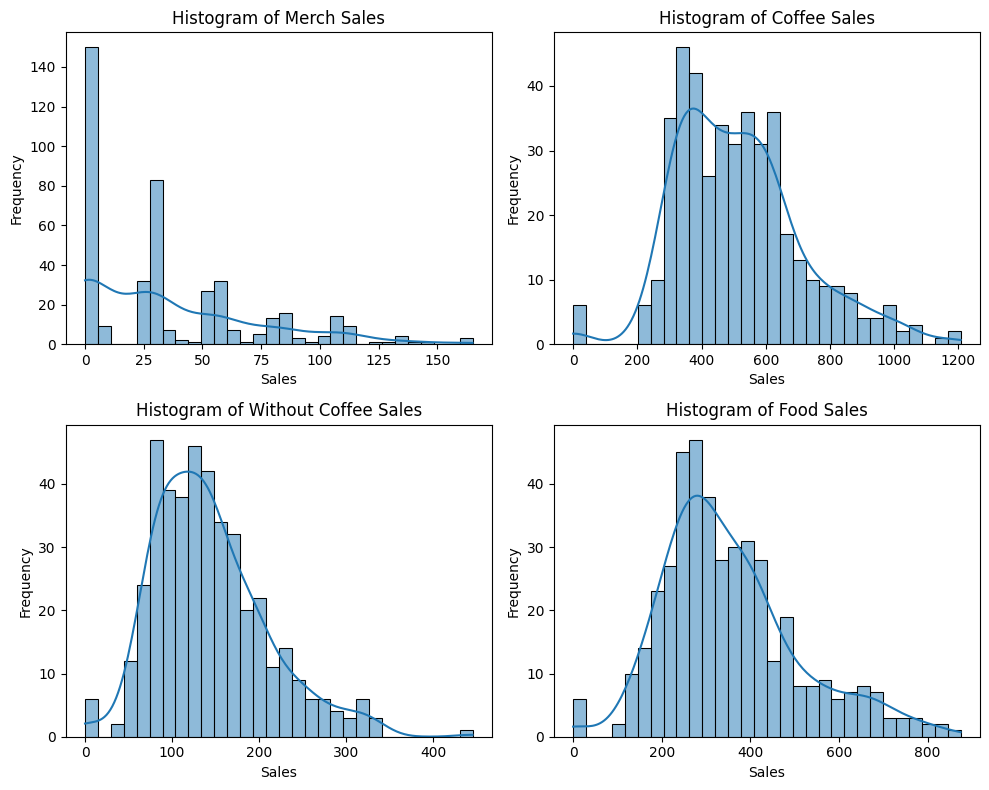

In [30]:
vs.hist_plot_categories(data_final, categories)

In [101]:
data_final_xgb = dp.remove_outliers(data_final, categories, 3)
data_final_ridge = dp.remove_outliers(data_final, categories, 2)

##### XGBoost

In [102]:
xgb_params_log = {
        'model__regressor__max_depth': [2, 3, 7],
        'model__regressor__learning_rate': [0.01, 0.05],
        'model__regressor__n_estimators': [100, 150, 200],
        'model__regressor__min_child_weight': [1, 5],
        'model__regressor__subsample': [0.8, 1.0],
        'model__regressor__colsample_bytree': [0.8, 1.0],
        'model__regressor__gamma': [0, 0.1],
        'model__regressor__nthread': [-1]
}

In [103]:
xgb_params_regularized_log= {
    **xgb_params_log,
    'model__regressor__reg_alpha': [0.01, 0.1],            # L1 regularization
    'model__regressor__reg_lambda': [0.01, 0.1]            # L2 regularization
}

In [142]:
results_xgb_log, summary_xgb_log, residuals_xgb_log, xgb_models = mt.xgb_train_log(data_final_xgb, categories, 6, xgb_params_regularized_log, date_split='2024-11-01')


Metrics for Coffee:
Training Metrics:
RMSE: 50.8347
MAPE: 8.0929
R2: 0.9244

Test Metrics:
RMSE: 51.5202
MAPE: 7.6155
R2: 0.8713

Metrics for Without Coffee:
Training Metrics:
RMSE: 23.5645
MAPE: 13.3371
R2: 0.8465

Test Metrics:
RMSE: 33.9629
MAPE: 17.4664
R2: 0.7006

Metrics for Food:
Training Metrics:
RMSE: 51.5538
MAPE: 11.8498
R2: 0.8718

Test Metrics:
RMSE: 58.2571
MAPE: 15.0044
R2: 0.8420


##### Ridge regression


In [131]:
ridge_params_log = {
    'model__regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'model__regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'model__regressor__fit_intercept': [True, False],
    'model__regressor__positive': [True, False]
}

In [143]:
results_ridge_log, summary_ridge_log, residuals_log, ridge_models = mt.ridge_train_log(data_final_ridge, categories, 6, ridge_params_log, date_split='2024-11-01')


Metrics for Coffee:
Training Metrics:
RMSE: 60.5730
MAPE: 10.4768
R2: 0.8022

Test Metrics:
RMSE: 65.5307
MAPE: 10.3761
R2: 0.5434

Metrics for Without Coffee:
Training Metrics:
RMSE: 27.8057
MAPE: 18.4998
R2: 0.6284

Test Metrics:
RMSE: 26.1765
MAPE: 15.2049
R2: 0.5229

Metrics for Food:
Training Metrics:
RMSE: 65.4595
MAPE: 17.3575
R2: 0.5882

Test Metrics:
RMSE: 59.8177
MAPE: 18.1595
R2: 0.4934


**Without outliers & test_size = 30**

In [144]:
summary_ridge_log

Category  Train RMSE  Train MAPE  Train R2  Train Accuracy 20  \
0          Coffee   60.573019   10.476787  0.802173          25.872093   
1  Without Coffee   27.805739   18.499830  0.628363          56.686047   
2            Food   65.459498   17.357477  0.588158          25.581395   

   Train Accuracy 50  Train Accuracy 100  Test RMSE  Test MAPE   Test R2  \
0          59.883721           89.825581  65.530693  10.376098  0.543406   
1          92.151163           99.709302  26.176534  15.204890  0.522887   
2          55.523256           87.790698  59.817747  18.159463  0.493412   

     CV RMSE  Test Accuracy 20  Test Accuracy 50  Test Accuracy 100  
0  77.718826         27.272727         54.545455          81.818182  
1  32.391340         54.545455         86.363636         100.000000  
2  76.836341         22.727273         63.636364          90.909091

In [145]:
summary_xgb_log

Category  Train RMSE  Train MAPE  Train R2  Train Accuracy 20  \
0          Coffee   50.834653    8.092917  0.924438          34.782609   
1  Without Coffee   23.564549   13.337090  0.846545          68.286445   
2            Food   51.553753   11.849820  0.871849          34.015345   

   Train Accuracy 50  Train Accuracy 100  Test RMSE  Test MAPE   Test R2  \
0          68.797954           94.884910  51.520163   7.615495  0.871269   
1          95.140665          100.000000  33.962918  17.466404  0.700604   
2          72.378517           93.094629  58.257100  15.004406  0.842026   

     CV RMSE  Test Accuracy 20  Test Accuracy 50  Test Accuracy 100  
0  90.365372         17.857143         75.000000          92.857143  
1  40.775830         50.000000         92.857143         100.000000  
2  85.613147         14.285714         57.142857          89.285714

In [135]:
summary = pd.concat([summary_xgb_log, summary_ridge_log], axis=0)
summary.index = ['XGB'] * 3 + ['Ridge'] * 3
summary

Category  Train RMSE  Train MAPE  Train R2  Train Accuracy 20  \
XGB            Coffee   50.834653    8.092917  0.924438          34.782609   
XGB    Without Coffee   23.564549   13.337090  0.846545          68.286445   
XGB              Food   51.553753   11.849820  0.871849          34.015345   
Ridge          Coffee   60.573019   10.476787  0.802173          25.872093   
Ridge  Without Coffee   27.805739   18.499830  0.628363          56.686047   
Ridge            Food   65.459498   17.357477  0.588158          25.581395   

       Train Accuracy 50  Train Accuracy 100  Test RMSE  Test MAPE   Test R2  \
XGB            68.797954           94.884910  51.520163   7.615495  0.871269   
XGB            95.140665          100.000000  33.962918  17.466404  0.700604   
XGB            72.378517           93.094629  58.257100  15.004406  0.842026   
Ridge          59.883721           89.825581  65.530693  10.376098  0.543406   
Ridge          92.151163           99.709302  26.176534  15.204890  0.522887   
Ridge          55.523256           87.790698  59.817747  18.159463  0.493412   

         CV RMSE  Test Accuracy 20  Test Accuracy 50  Test Accuracy 100  
XGB    90.365372         17.857143         75.000000          92.857143  
XGB    40.775830         50.000000         92.857143         100.000000  
XGB    85.613147         14.285714         57.142857          89.285714  
Ridge  77.718826         27.272727         54.545455          81.818182  
Ridge  32.391340         54.545455         86.363636         100.000000  
Ridge  76.836341         22.727273         63.636364          90.909091

### Error Analysis

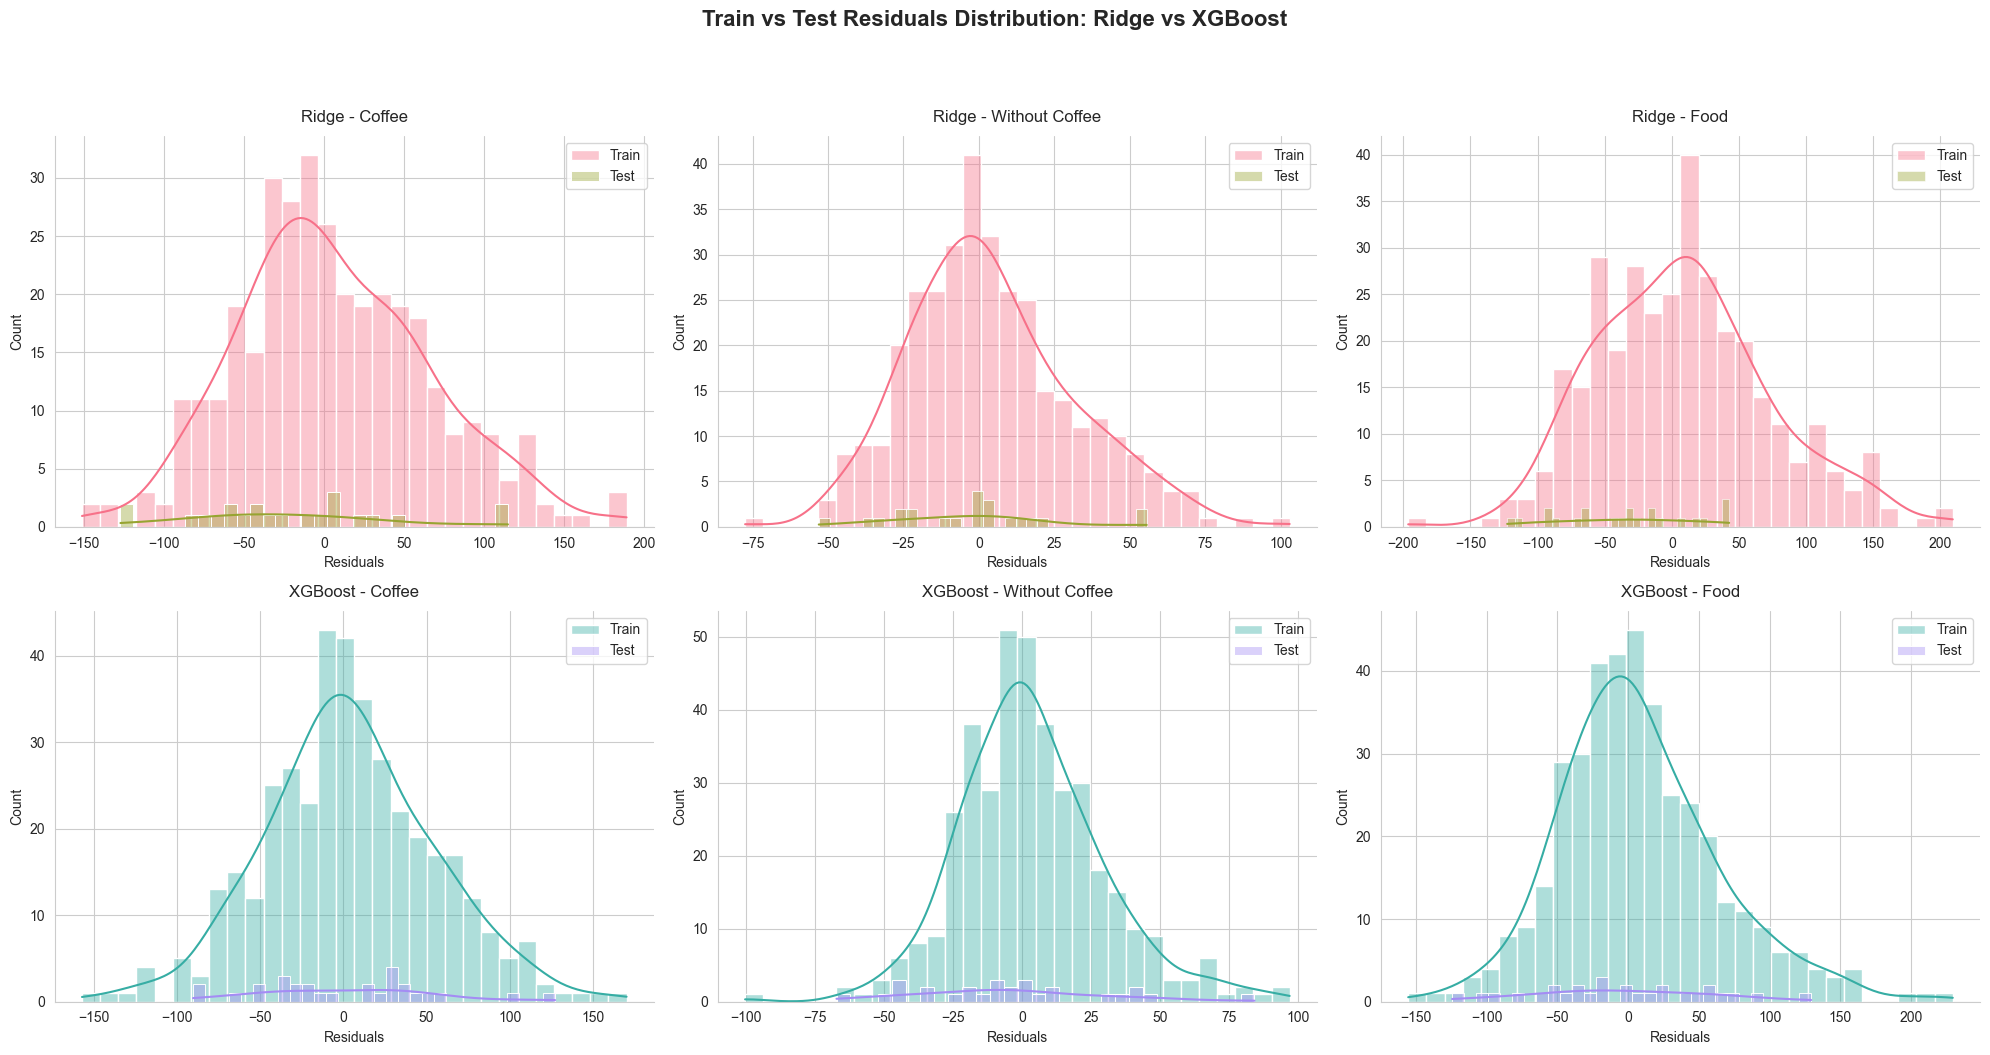

In [113]:
vs.hist_residuals_comparison(residuals_log, residuals_xgb_log, categories)

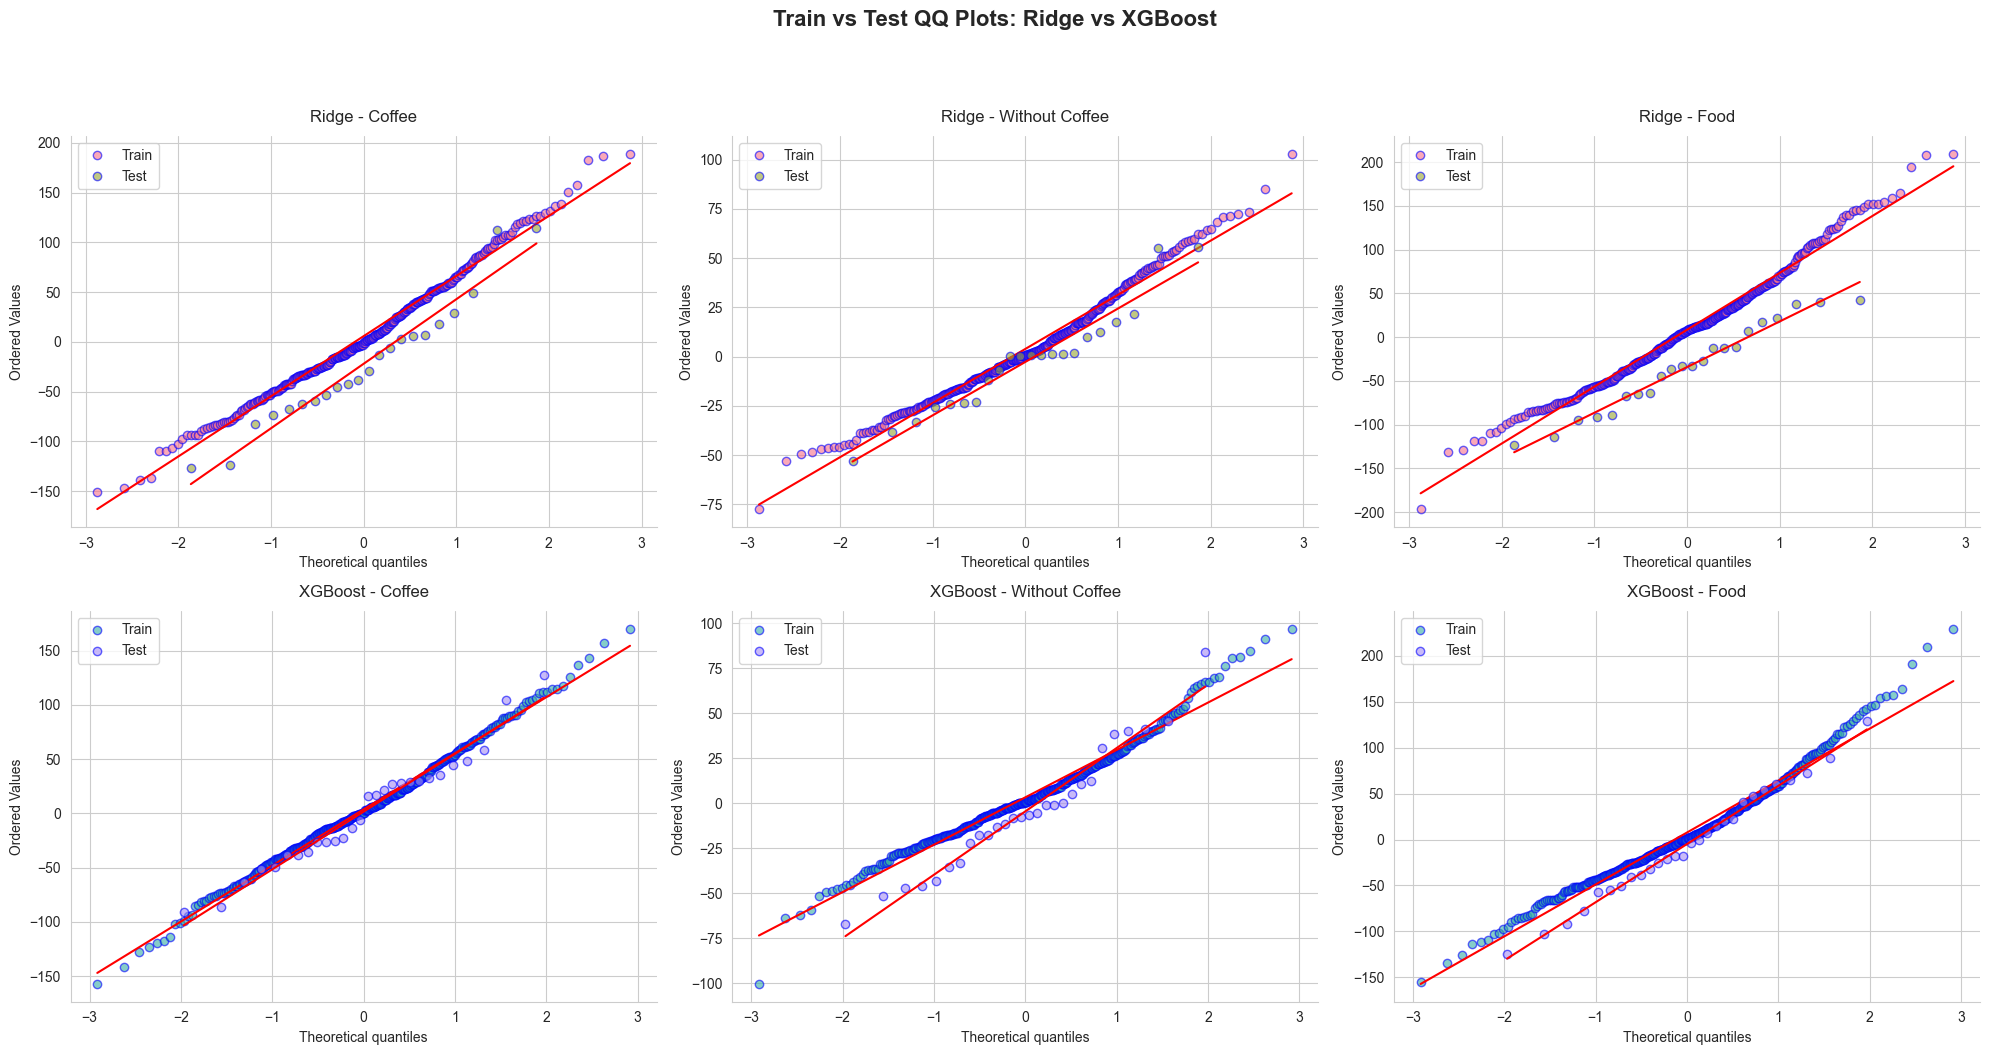

In [114]:
vs.plot_qq_comparison(residuals_log, residuals_xgb_log, categories)

## Model Comparison Summary (Excluding Merch)

Below, each category’s key metrics are shown for **XGBoost** vs. **Ridge**.  
We compare **R²**, **RMSE**, **MAPE**, and the accuracy within ±20, ±50, ±100 of actual sales.

---

### Coffee

- **XGBoost**  
  - **R²**: 0.87  
  - RMSE: ~51  
  - MAPE: ~7.65%  
  - Accuracy ±20: ~14%  
  - Accuracy ±50: ~75%  
  - Accuracy ±100: ~93%  

- **Ridge**  
  - **R²**: 0.54  
  - RMSE: ~65  
  - MAPE: ~10.38%  
  - Accuracy ±20: ~27%  
  - Accuracy ±50: ~55%  
  - Accuracy ±100: ~82%  

**Verdict (Coffee)**: XGBoost shows a much higher R² and lower MAPE, indicating better overall fit and smaller relative errors, though Ridge has a slightly higher ±20 accuracy.  
**Preferred**: **XGBoost**.

---

### Without Coffee

- **XGBoost**  
  - **R²**: ~0.70  
  - RMSE: ~34  
  - MAPE: ~17.63%  
  - Accuracy ±20: ~50%  
  - Accuracy ±50: ~89%  
  - Accuracy ±100: ~100%

- **Ridge**  
  - **R²**: ~0.52  
  - RMSE: ~26  
  - MAPE: ~15.20%  
  - Accuracy ±20: ~55%  
  - Accuracy ±50: ~86%  
  - Accuracy ±100: ~100%

**Verdict (Without Coffee)**: XGBoost captures more variance (higher R²) and tends to handle big swings better. Ridge has slightly lower MAPE and higher ±20 accuracy. Depending on priorities (variance capture vs. day-to-day consistency), either could be justified, but **XGBoost** typically wins for overall forecasting performance.

---

### Food

- **XGBoost**  
  - **R²**: ~0.83  
  - RMSE: ~60  
  - MAPE: ~15.18%  
  - Accuracy ±20: ~21%  
  - Accuracy ±50: ~54%  
  - Accuracy ±100: ~89%

- **Ridge**  
  - **R²**: ~0.49  
  - RMSE: ~60  
  - MAPE: ~18.16%  
  - Accuracy ±20: ~23%  
  - Accuracy ±50: ~64%  
  - Accuracy ±100: ~91%

**Verdict (Food)**: XGBoost has a far higher R² and lower MAPE; Ridge only edges out slightly on ±20 accuracy.  
**Preferred**: **XGBoost**.

---

## Are These Models Good Enough?

Given **fewer than 500 total records**, achieving R² values around 0.70–0.87 for Coffee and Food is **quite strong**. The models do show larger errors for certain outlier days (especially “Without Coffee”), but that’s expected with limited data and potentially volatile sales. Overall, **these performances are reasonable**, though further feature engineering or robust methods might boost tail accuracy and reduce day-to-day errors.

## Save the models

In [163]:
# Save xgb models using dill
for category, model in xgb_models.items():
    filename = f"xgb_model_{category}.pkl"
    with open(filename, "wb") as f:
        dill.dump(model, f)
    print(f"Saved best model for {category} to {filename}")

Saved best model for Coffee to xgb_model_Coffee.pkl
Saved best model for Without Coffee to xgb_model_Without Coffee.pkl
Saved best model for Food to xgb_model_Food.pkl


In [164]:
filename = f'ridge_model_Without Coffee.pkl'
with open(filename, "wb") as f:
    dill.dump(ridge_models, f)
print(f"Saved best model for Without Coffe to {filename}") 

Saved best model for Without Coffe to ridge_model_Without Coffee.pkl
